# PFPF Filter: Function-Based Implementation

This notebook implements the **Particle Flow Particle Filter (PFPF)** using **pure functions** (no classes).

Each function directly corresponds to specific lines in **Algorithm 1 (PF-PF LEDH)** and **Algorithm 2 (PF-PF EDH)** from Li & Coates (2017).

## Algorithm 1: PF-PF (LEDH) - Local Linearization

```
Initialization:
  1  Draw {x_0^i}_{i=1}^Np from the prior p_0(x)
  2  Set {w_0^i}_{i=1}^Np = 1/Np
  3  for k = 1 to K do
  4    for i = 1, ..., Np do
  5      Apply EKF/UKF prediction: (x_{k-1}^i, P_{k-1}^i) → (m_{k|k-1}^i, P^i)
  6      Calculate η̄^i = g_k(x_{k-1}^i, 0)
  7      Propagate particles: η_0^i = g_k(x_{k-1}^i, v_k)
  8      Set η_1^i = η_0^i and θ^i = 1
  9      Calculate η̄_0^i = g_k(x_{k-1}^i, 0)
 10    endfor
 11    Set λ = 0
 12    for j = 1, ..., N_λ do
 13      Set λ = λ + ε_j
 14      for i = 1, ..., Np do
 15        Set η̄_0 = η̄_0^i and P = P^i
 16        Calculate A_j^i(λ) and b_j^i(λ) with linearization at η̄^i
 17        Migrate η̄^i: η̄^i = η̄^i + ε_j(A_j^i(λ)η̄^i + b_j^i(λ))
 18        Migrate particles: η_1^i = η_1^i + ε_j(A_j^i(λ)η_1^i + b_j^i(λ))
 19        Calculate θ^i = θ^i / |det(I + ε_j A_j^i(λ))|
 20      endfor
 21    endfor
 22    for i = 1, ..., Np do
 23      Set x_k^i = η_1^i
 24      w_k^i = [p(x_k^i|x_{k-1}^i)p(z_k|x_k^i)θ^i / p(η_0^i|x_{k-1}^i)] w_{k-1}^i
 25    endfor
 26    Normalize weights
 27    Apply EKF/UKF update for each particle
 28    Estimate x̂_k
 29    (Optional) Resample
 30  endfor
```

## Algorithm 2: PF-PF (EDH) - Global Linearization

```
Initialization:
  1  Draw {x_0^i}_{i=1}^Np from p_0(x)
  2  Set {w_0^i}_{i=1}^Np = 1/Np
  3  for k = 1 to K do
  4    Apply EKF/UKF prediction: (x̂_{k-1}, P_{k-1}) → (m_{k|k-1}, P)
  5    for i = 1, ..., Np do
  6      Propagate particles: η_0^i = g_k(x_{k-1}^i, v_k)
  7      Set η_1^i = η_0^i
  8    endfor
  9    Calculate η̄_0 = g_k(x̂_{k-1}, 0) and set η̄ = η̄_0
 10    Set λ = 0
 11    for j = 1, ..., N_λ do
 12      Set λ = λ + ε_j
 13      Calculate A_j(λ) and b_j(λ) with linearization at η̄
 14      Migrate η̄: η̄ = η̄ + ε_j(A_j(λ)η̄ + b_j(λ))
 15      for i = 1, ..., Np do
 16        Migrate particles: η_1^i = η_1^i + ε_j(A_j(λ)η_1^i + b_j(λ))
 17      endfor
 18    endfor
 19    for i = 1, ..., Np do
 20      Set x_k^i = η_1^i
 21      w_k^i = [p(x_k^i|x_{k-1}^i)p(z_k|x_k^i) / p(η_0^i|x_{k-1}^i)] w_{k-1}^i
 22    endfor
 23    Normalize weights
 24    Apply EKF/UKF update: (m_{k|k-1}, P) → (m_{k|k}, P_k)
 25    Estimate x̂_k
 26    (Optional) Resample
 27  endfor
```

## References

- **Li & Coates (2017)**: "Particle Filtering with Invertible Particle Flow", arXiv:1607.08799
- **MATLAB Code**: Algorithm 1 and Algorithm 2 in the paper

## 1. Setup and Imports

In [51]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
tfd = tfp.distributions

# Import acoustic model functions
import sys
sys.path.append('..')
from acoustic_function import (
    initialize_acoustic_model,
    state_transition,
    observation_model,
    compute_observation_jacobian,
    simulate_trajectory
)

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow version: 2.20.0
GPU available: False


## 2. Initialize Acoustic Model

In [2]:
# Initialize acoustic model with default parameters (4 targets, 25 sensors)
model_params = initialize_acoustic_model(n_targets=4)

print(f"Configuration:")
print(f"  Targets: {model_params['n_targets']}")
print(f"  Sensors: {model_params['n_sensors']} (5×5 grid)")
print(f"  State dimension: {model_params['state_dim']}")
print(f"  Surveillance area: {model_params['sim_area_size']}m × {model_params['sim_area_size']}m")
print(f"\nAcoustic Parameters:")
print(f"  Amplitude (Ψ): {model_params['amplitude'].numpy()}")
print(f"  Measurement noise std: {model_params['measurement_noise_std']}")

Configuration:
  Targets: 4
  Sensors: 25 (5×5 grid)
  State dimension: 16
  Surveillance area: 40.0m × 40.0m

Acoustic Parameters:
  Amplitude (Ψ): 10.0
  Measurement noise std: 0.1


## 3. PFPF Filter Functions

Each function below corresponds to specific lines in Algorithm 1 (LEDH) and Algorithm 2 (EDH).

### Function 1: Compute Lambda Steps

**Purpose**: Compute exponentially spaced lambda steps for particle flow.

**Algorithm**: Pre-processing (before Algorithm 1/2)

**Equations**:
- Step sizes: $\epsilon_j = \epsilon_1 \cdot q^{j-1}$ for $j = 1, ..., N_\lambda$
- Constraint: $\sum_{j=1}^{N_\lambda} \epsilon_j = 1$
- Solution: $\epsilon_1 = \frac{1-q}{1-q^{N_\lambda}}$ where $q > 1$ (typically $q = 1.2$)
- Lambda values: $\lambda_j = \sum_{i=1}^{j} \epsilon_i$

**Reference**: Same as EDH filter

In [3]:
def compute_lambda_steps(n_lambda, lambda_ratio):
    """
    Compute exponentially spaced lambda steps.
    
    Args:
        n_lambda: Number of lambda steps (typically 20)
        lambda_ratio: Ratio for exponential spacing (typically 1.2)
    
    Returns:
        lambda_steps: Step sizes ε_j, shape (n_lambda,)
        lambda_values: Cumulative lambda values λ_j, shape (n_lambda,)
    """
    q = lambda_ratio
    n = n_lambda
    
    # Initial step size: ε_1 = (1-q)/(1-q^n)
    epsilon_1 = (1 - q) / (1 - q**n)
    
    # Step sizes: ε_j = ε_1 * q^(j-1) for j=1,...,n
    step_sizes = [epsilon_1 * (q**j) for j in range(n)]
    lambda_steps = tf.constant(step_sizes, dtype=tf.float32)
    
    # Cumulative lambda values: λ_j = Σ_{i=1}^j ε_i
    lambda_values = tf.cumsum(lambda_steps)
    
    return lambda_steps, lambda_values

### Function 2: Initialize Particles

**Algorithm Lines 1-2 (both LEDH and EDH)**

**Purpose**: Draw initial particles from prior distribution and initialize weights.

**Equations**:
- Draw: $x_0^{(i)} \sim \mathcal{N}(x_0, P_0)$ for $i = 1, ..., N$
- Initial weights: $w_0^{(i)} = 1/N_p$
- Initial mean: $x_0$
- Initial covariance: $P_0 = \text{diag}(\sigma_0^2)$

In [4]:
def initialize_particles(model_params, n_particle):
    """
    Initialize particles from Gaussian prior.

    Algorithm Lines 1-2:
      1  Draw {x_0^i}_{i=1}^N from the prior p_0(x)
      2  Set {w_0^i}_{i=1}^N = 1/Np

    Args:
        model_params: Dictionary from initialize_acoustic_model()
        n_particle: Number of particles

    Returns:
        particles: Initial particles, shape (state_dim, n_particle)
        weights: Initial weights, shape (n_particle,)
        m0: Random initial mean, shape (state_dim, 1)
        P0: Initial covariance, shape (state_dim, state_dim)
    """
    state_dim = model_params['state_dim']
    x0 = model_params['x0_initial_target_states']  # (state_dim, 1)
    n_targets = model_params['n_targets']
    sim_area_size = model_params['sim_area_size']

    # Initial uncertainty from paper
    sigma0_single = tf.constant(
        [0.1**0.5, 0.1**0.5, 0.0005**0.5, 0.0005**0.5],
        dtype=tf.float32
    )    
    sigma0 = tf.tile(sigma0_single, [n_targets])
    # Line 2: P_0 = diag(σ_0^2)
    P0 = tf.linalg.diag(tf.square(sigma0))

    # Sample random mean m0 and ensure it's within bounds
    out_of_bound = True
    while out_of_bound:
        noise = tf.random.normal((state_dim, 1), dtype=tf.float32)
        m0 = x0 + tf.expand_dims(sigma0, 1) * noise

        # Check if all target positions are within surveillance region
        x_positions = m0[0::4, 0]  # indices 0, 4, 8, 12, ... (x positions)
        y_positions = m0[1::4, 0]  # indices 1, 5, 9, 13, ... (y positions)

        # Check bounds: all positions should be in [0, sim_area_size]
        x_in_bounds = tf.reduce_all(x_positions >= 0.0) and tf.reduce_all(x_positions <= sim_area_size)
        y_in_bounds = tf.reduce_all(y_positions >= 0.0) and tf.reduce_all(y_positions <= sim_area_size)

        if x_in_bounds and y_in_bounds:
            out_of_bound = False

    # Sample particles around m0
    noise = tf.random.normal((state_dim, n_particle), dtype=tf.float32)
    particles = m0 + tf.expand_dims(sigma0, 1) * noise
    
    # Initialize uniform weights
    weights = tf.ones(n_particle, dtype=tf.float32) / n_particle

    return particles, weights, m0, P0

### Function 3: Propagate Particles

**Algorithm Line 7 (LEDH) / Line 6 (EDH)**

**Purpose**: Propagate particles through motion model.

**Equation**:
$$\eta_0^{(i)} = g_k(x_{k-1}^{(i)}, v_k), \quad v_k \sim \mathcal{N}(0, Q)$$

where:
- $g_k$ is the state transition function
- $Q$ is the process noise covariance

In [5]:
def propagate_particles(particles, model_params, no_noise=False):
    """
    Propagate particles through motion model.
    
    Algorithm Line 7 (LEDH) / Line 6 (EDH):
      Propagate particles η_0^i = g_k(x_{k-1}^i, v_k)
    
    Equation:
      x_k = Φ * x_{k-1} + w_k,  where w_k ~ N(0, Q)
    
    Args:
        particles: Current particles, shape (state_dim, n_particle)
        model_params: Dictionary with 'Phi' and 'Q'
    
    Returns:
        particles_pred: Predicted particles, shape (state_dim, n_particle)
    """
    state_dim = model_params['state_dim']
    Phi = model_params['Phi']  # State transition matrix
    Q = model_params['Q']      # Process noise covariance
    n_particle = tf.shape(particles)[1]
    
    # Linear propagation: x_k = Φ * x_{k-1}
    particles_pred = tf.matmul(Phi, particles)
    
    # no nosie
    if no_noise:
        return particles_pred

    # Add process noise: w_k ~ N(0, Q)
    Q_chol = tf.linalg.cholesky(Q)
    noise = tf.matmul(Q_chol, tf.random.normal((state_dim, n_particle), dtype=tf.float32))
    
    return particles_pred + noise

### Function 4: Estimate Covariance from Particles

**Algorithm Lines 5 (LEDH) / Line 4 (EDH)**

**Purpose**: Estimate covariance matrix from particle spread.

**Equation**:
$$P = \frac{1}{N-1} \sum_{i=1}^N (x^{(i)} - \bar{x})(x^{(i)} - \bar{x})^T$$

where $\bar{x} = \frac{1}{N} \sum_{i=1}^N x^{(i)}$

In [6]:
def estimate_covariance(particles):
    """
    Estimate covariance from particles.
    
    Algorithm Line 5 (LEDH) / Line 4 (EDH): P prediction
    
    Equation:
      P = (1/(N-1)) * Σ (x_i - x̄)(x_i - x̄)^T
    
    Args:
        particles: Particles, shape (state_dim, n_particle)
    
    Returns:
        P: Covariance matrix, shape (state_dim, state_dim)
    """
    # Compute mean
    mean = tf.reduce_mean(particles, axis=1, keepdims=True)
    
    # Center particles
    centered = particles - mean
    
    # Covariance: P = (1/(N-1)) * centered @ centered^T
    n_particles = tf.cast(tf.shape(particles)[1], tf.float32)
    P = tf.matmul(centered, tf.transpose(centered)) / (n_particles - 1.0)
    
    # Add small regularization for numerical stability
    P = P + 1e-6 * tf.eye(tf.shape(P)[0], dtype=tf.float32)
    
    return P

### Function 5: Compute Flow Parameters A and b

**Algorithm Line 16 (LEDH) / Line 13 (EDH)**

**Purpose**: Compute flow matrix $A(\lambda)$ and flow vector $b(\lambda)$ for particle flow.

**Equations** (from Li & Coates 2017, following EDH equations):

$$A(\lambda) = -\frac{1}{2} P H^T (\lambda H P H^T + R)^{-1} H$$

$$b(\lambda) = (I + 2\lambda A)[(I + \lambda A) P H^T R^{-1} (z - e) + A\bar{\eta}_0]$$

where:
- $H = \frac{\partial h}{\partial x}|_{\bar{\eta}}$ is the observation Jacobian
- $e = h(\bar{\eta}) - H\bar{\eta}$ is the linearization residual
- $z$ is the current measurement
- $P$ is the covariance (should be $P_{k|k-1}$)
- $R$ is the measurement noise covariance

### Function 6: Particle Flow (LEDH - Local Linearization)

**Algorithm Lines 11-21 (LEDH)**

**Purpose**: Migrate particles from prior to posterior using particle flow with **local linearization**.

**Flow ODE**:
$$\frac{d\eta}{d\lambda} = A^i(\lambda) \eta^i + b^i(\lambda)$$

**Numerical integration** (Euler method):
$$\eta^{i,(j+1)} = \eta^{i,(j)} + \epsilon_j [A^i(\lambda_j) \eta^{i,(j)} + b^i(\lambda_j)]$$

where $A^i$ and $b^i$ are computed with linearization at each particle position.

In [7]:
# def particle_flow_ledh(particles, measurement, P_pred, lambda_steps, lambda_values,
#                        eta_bar_mu_0_list, model_params):
#     """
#     Migrate particles from prior to posterior using LEDH flow (local linearization).

#     Algorithm Lines 11-21 (LEDH):
#       11  Set λ = 0
#       12  for j = 1, ..., N_λ do
#       13    Set λ = λ + ε_j
#       14    for i = 1, ..., Np do
#       15      Set η̄_0 = η̄_0^i and P = P^i
#       16      Calculate A_j^i(λ) and b_j^i(λ) with linearization at η̄^i
#       17      Migrate η̄^i
#       18      Migrate particles
#       19      Calculate θ^i = θ^i / |det(I + ε_j A_j^i(λ))|
#       20    endfor
#       21  endfor

#     JACOBIAN DETERMINANT CALCULATION (for weight update):
    
#     The particle flow defines a mapping T: η_0 → η_1 via the ODE:
#       dη/dλ = A^i(λ)η + b^i(λ)
    
#     The Jacobian of this mapping is needed for importance weight correction.
#     For Euler discretization with step size ε_j:
#       η_{j+1} = η_j + ε_j(A_j η_j + b_j)
      
#     The Jacobian matrix is:
#       J_j = ∂η_{j+1}/∂η_j = I + ε_j A_j
      
#     The total Jacobian is the product:
#       J_total = ∏_{j=1}^{N_λ} J_j = ∏_{j=1}^{N_λ} (I + ε_j A_j)
      
#     For numerical stability, we work in log space:
#       log|det(J_total)| = ∑_{j=1}^{N_λ} log|det(I + ε_j A_j)|
      
#     This sum is accumulated and used in the weight update formula.

#     Args:
#         particles: Predicted particles, shape (state_dim, n_particle)
#         measurement: Current measurement, shape (n_sensor, 1)
#         P_pred: List of prior covariances P^i, each shape (state_dim, state_dim)
#         lambda_steps: Step sizes ε_j, shape (n_lambda,)
#         lambda_values: Cumulative lambda values λ_j, shape (n_lambda,)
#         eta_bar_mu_0_list: List of mean trajectories η̄_0^i, each shape (state_dim, 1)
#         model_params: Dictionary with observation model

#     Returns:
#         particles_flowed: Updated particles, shape (state_dim, n_particle)
#         log_jacobian_det_sum: Sum of log determinants ∑_j log|det(I + ε_j A_j^i)|, shape (n_particle,)
#     """
#     # Initialize flow
#     eta = tf.identity(particles)  # Current particle positions
#     n_particle = tf.shape(particles)[1].numpy()
#     n_lambda = len(lambda_steps)
#     state_dim = tf.shape(particles)[0].numpy()
    
#     # Initialize auxiliary trajectories for linearization points
#     eta_bar_list = [tf.identity(eta_bar_mu_0_list[i]) for i in range(n_particle)]
    
#     # Initialize log jacobian determinant sums (log space for numerical stability)
#     # This will store: ∑_{j=1}^{N_λ} log|det(I + ε_j A_j^i)| for each particle i
#     log_jacobian_det_sum = tf.zeros(n_particle, dtype=tf.float32)
    
#     # Algorithm Line 11: Set λ = 0
#     # Algorithm Line 12: for j = 1, ..., N_λ do
#     for j in range(n_lambda):
#         # Algorithm Line 13: Set λ = λ + ε_j
#         epsilon_j = lambda_steps[j].numpy()   # Step size
#         lambda_j = lambda_values[j]   # Current lambda value
        
#         # Store updated values for this step
#         log_det_updates = []
#         eta_updates = []
#         eta_bar_updates = []
        
#         # Algorithm Line 14: for i = 1, ..., Np do
#         for i in range(n_particle):
#             # Algorithm Line 15: Set η̄_0 = η̄_0^i and P = P^i
#             x_i = tf.expand_dims(eta[:, i], 1)  # (state_dim, 1)
#             eta_bar_i = eta_bar_list[i]  # (state_dim, 1)
#             P_i = P_pred[i]  # (state_dim, state_dim)
#             eta_bar_mu_0_i = eta_bar_mu_0_list[i]  # (state_dim, 1)
            
#             # Algorithm Line 16: Compute A_i, b_i for THIS particle
#             # Linearization at η̄^i (auxiliary trajectory)
#             A_i, b_i = compute_flow_parameters(eta_bar_i, eta_bar_mu_0_i, P_i, measurement,
#                                                lambda_j, model_params)
            
#             # Algorithm Line 17: Migrate η̄^i
#             slope_bar = tf.linalg.matvec(A_i, tf.squeeze(eta_bar_i)) + b_i
#             eta_bar_new = eta_bar_i + epsilon_j * tf.expand_dims(slope_bar, 1)
            
#             # Algorithm Line 18: Migrate particles
#             # Euler step: η_{j+1} = η_j + ε_j(A_j η_j + b_j)
#             slope_i = tf.linalg.matvec(A_i, tf.squeeze(x_i)) + b_i
#             x_new = x_i + epsilon_j * tf.expand_dims(slope_i, 1)
            
#             # Algorithm Line 19: Calculate log|det(I + ε_j A_j^i(λ))| and accumulate
#             # Jacobian of the Euler step: J = I + ε_j A_j
#             I = tf.eye(state_dim, dtype=tf.float32)
#             det_jacobian = tf.linalg.det(I + epsilon_j * A_i)
            
#             # Add log determinant to running sum (log space is numerically stable)
#             log_det = tf.math.log(tf.abs(det_jacobian) + 1e-30)
#             log_det_new = log_jacobian_det_sum[i] + log_det
            
#             # Store updates
#             log_det_updates.append(log_det_new)
#             eta_updates.append(tf.squeeze(x_new, axis=1))
#             eta_bar_updates.append(eta_bar_new)
        
#         # Update all particles and log determinant sums
#         log_jacobian_det_sum = tf.stack(log_det_updates)
#         eta = tf.stack(eta_updates, axis=1)
#         eta_bar_list = eta_bar_updates
    
#     return eta, log_jacobian_det_sum

### Function 7: Particle Flow (EDH - Global Linearization)

**Algorithm Lines 10-18 (EDH)**

**Purpose**: Migrate particles from prior to posterior using particle flow with **global linearization**.

**Flow ODE**:
$$\frac{d\eta}{d\lambda} = A(\lambda) \eta + b(\lambda)$$

**Key difference from LEDH**: Uses the same $A$ and $b$ for all particles, computed at the global mean.

In [8]:
# def particle_flow_edh(particles, measurement, P_pred, lambda_steps, lambda_values,
#                       eta_bar_mu_0, model_params):
#     """
#     Migrate particles from prior to posterior using EDH flow (global linearization).

#     Algorithm Lines 10-18 (EDH):
#       10  Set λ = 0
#       11  for j = 1, ..., N_λ do
#       12    Set λ = λ + ε_j
#       13    Calculate A_j(λ) and b_j(λ) with linearization at η̄
#       14    Migrate η̄
#       15    for i = 1, ..., Np do
#       16      Migrate particles
#       17    endfor
#       18  endfor

#     Args:
#         particles: Predicted particles, shape (state_dim, n_particle)
#         measurement: Current measurement, shape (n_sensor, 1)
#         P_pred: Prior covariance P, shape (state_dim, state_dim)
#         lambda_steps: Step sizes ε_j, shape (n_lambda,)
#         lambda_values: Cumulative lambda values λ_j, shape (n_lambda,)
#         eta_bar_mu_0: Mean trajectory η̄_0, shape (state_dim, 1)
#         model_params: Dictionary with observation model

#     Returns:
#         particles_flowed: Updated particles, shape (state_dim, n_particle)
#     """
#     # Initialize flow
#     eta = tf.identity(particles)  # Current particle positions
#     n_lambda = len(lambda_steps)
    
#     # Initialize auxiliary trajectory for global linearization
#     eta_bar = tf.identity(eta_bar_mu_0)
    
#     # Algorithm Line 10: Set λ = 0
#     # Algorithm Line 11: for j = 1, ..., N_λ do
#     for j in range(n_lambda):
#         # Algorithm Line 12: Set λ = λ + ε_j
#         epsilon_j = lambda_steps[j].numpy()   # Step size
#         lambda_j = lambda_values[j]   # Current lambda value
        
#         # Algorithm Line 13: Compute A, b ONCE at global mean η̄
#         A, b = compute_flow_parameters(eta_bar, eta_bar_mu_0, P_pred, measurement,
#                                       lambda_j, model_params)
        
#         # Algorithm Line 14: Migrate η̄
#         slope_bar = tf.linalg.matvec(A, tf.squeeze(eta_bar)) + b
#         eta_bar = eta_bar + epsilon_j * tf.expand_dims(slope_bar, 1)
        
#         # Algorithm Lines 15-17: Migrate all particles using the same A, b
#         slopes = tf.matmul(A, eta) + tf.expand_dims(b, 1)
#         eta = eta + epsilon_j * slopes
    
#     return eta

### Function 8: Log Gaussian PDF (loggausspdf.m)

**Algorithm**: Helper function for weight calculations

**Purpose**: Calculate log of d-dimensional Gaussian probability density.

**MATLAB Reference**: loggausspdf.m lines 24-26

**Equation**:
$$\log p(x) = -\frac{1}{2}[(x-\mu)^T \Sigma^{-1} (x-\mu) + \log|\Sigma| + d\log(2\pi)]$$

This function directly mirrors the MATLAB loggausspdf.m implementation.

In [12]:
def compute_log_likelihood(xp, measurement, model_params):
    """
    Compute log likelihood p(z_k|x_k) for all particles.
    
    MATLAB Reference: correctoinAndCalculateWeights.m line 20
    
    This function exactly mirrors the MATLAB implementation:
    -------------------------------------------------------
    MATLAB code:
        llh = ps.likeparams.llh(vg.xp, z_current, ps.likeparams);
    -------------------------------------------------------
    
    For Gaussian measurement model:
        p(z_k|x_k) = N(z_k; h(x_k), R)
    
    Args:
        xp: Particles, shape (state_dim, n_particle)
        measurement: Current measurement, shape (n_sensor, 1)
        model_params: Dictionary with observation model and R
    
    Returns:
        llh: Log likelihood for each particle, shape (n_particle,)
    """
    n_particle = tf.shape(xp)[1]
    n_sensor = model_params['n_sensors']
    R = model_params['R']
    
    # Pre-compute for efficiency
    regularization = 1e-6 * tf.eye(n_sensor, dtype=tf.float32)
    R_regularized = R + regularization
    R_chol = tf.linalg.cholesky(R_regularized)
    log_det_R = 2.0 * tf.reduce_sum(tf.math.log(tf.linalg.diag_part(R_chol)))
    
    llh_list = []
    for i in range(n_particle.numpy()):
        x_i = tf.expand_dims(xp[:, i], 1)  # (state_dim, 1)
        
        # Predicted measurement: h(x_i)
        z_pred = observation_model(x_i, model_params, no_noise=True)
        
        # Innovation: z - h(x_i)
        innovation = measurement - z_pred
        
        # Log likelihood using Cholesky
        alpha = tf.linalg.cholesky_solve(R_chol, innovation)
        mahalanobis = tf.matmul(tf.transpose(innovation), alpha)[0, 0]
        
        # log p(z|x) = -0.5 * [mahalanobis + log|R| + n*log(2π)]
        log_lik = -0.5 * (mahalanobis + log_det_R + 
                         tf.cast(n_sensor, tf.float32) * tf.math.log(2.0 * np.pi))
        
        # Clamp for numerical stability
        log_lik = tf.clip_by_value(log_lik, -100.0, 100.0)
        llh_list.append(log_lik)
    
    llh = tf.stack(llh_list)
    return llh  # Shape: (n_particle,)

In [13]:
def correctoinAndCalculateWeights(particles_flowed, particles_pred, particles_pred_deterministic,
                                  weights_prev, measurement, log_jacobian_det_sum, model_params):
    """
    Calculate importance weights following MATLAB implementation.
    
    MATLAB Reference: correctoinAndCalculateWeights.m lines 16-23
    
    This function exactly mirrors the MATLAB implementation:
    -------------------------------------------------------
    MATLAB code (lines 16-23):
        log_proposal = log_proposal_density(vg,ps,log_jacobian_det_sum);
        
        log_prior = log_process_density(vg,ps);
        
        llh = ps.likeparams.llh(vg.xp,z_current,ps.likeparams);
        
        vg.logW = log_prior + llh - log_proposal + vg.logW;
        vg.logW = vg.logW - max(vg.logW);
    -------------------------------------------------------
    
    Weight update formula:
        w_k ∝ [p(x_k|x_{k-1}) * p(z_k|x_k) / q(x_k|x_{k-1},z_k)] * w_{k-1}
    
    In log space:
        log w_k = log p(x_k|x_{k-1}) + log p(z_k|x_k) - log q(...) + log w_{k-1}
    
    Args:
        particles_flowed: Particles after flow (x_k), shape (state_dim, n_particle)
        particles_pred: Propagated particles WITH noise (η_0), shape (state_dim, n_particle)
        particles_pred_deterministic: Deterministic propagation (Φ·x_{k-1}), shape (state_dim, n_particle)
        weights_prev: Previous weights, shape (n_particle,)
        measurement: Current measurement, shape (n_sensor, 1)
        log_jacobian_det_sum: Sum of log Jacobian determinants, shape (n_particle,)
        model_params: Dictionary with model parameters
    
    Returns:
        weights_updated: Updated normalized weights, shape (n_particle,)
    """
    Q = model_params['Q']
    
    # Line 16: Calculate log proposal density
    # log_proposal = log p(η_0|x_{k-1}) - log_jacobian_det_sum
    log_proposal = log_proposal_density(particles_pred, particles_pred_deterministic, 
                                       Q, log_jacobian_det_sum)
    
    # Line 18: Calculate log process/prior density
    # log_prior = log p(x_k|x_{k-1})
    log_prior = log_process_density(particles_flowed, particles_pred_deterministic, Q)
    
    # Line 20: Calculate log likelihood
    # llh = log p(z_k|x_k)
    llh = compute_log_likelihood(particles_flowed, measurement, model_params)
    
    # Line 22: Weight update
    # log w_k = log_prior + llh - log_proposal + log w_{k-1}
    log_weights_prev = tf.math.log(weights_prev + 1e-30)
    log_weights = log_prior + llh - log_proposal + log_weights_prev
    
    # Clamp for numerical stability
    log_weights = tf.clip_by_value(log_weights, -100.0, 100.0)
    
    # Line 23: Normalize by subtracting max
    log_weights = log_weights - tf.reduce_max(log_weights)
    
    # Convert back from log space
    weights_updated = tf.exp(log_weights)
    
    # Normalize so weights sum to 1
    weight_sum = tf.reduce_sum(weights_updated)
    if weight_sum > 1e-30:
        weights_updated = weights_updated / weight_sum
    else:
        # If all weights collapsed, reset to uniform
        n_particle = tf.shape(particles_flowed)[1]
        weights_updated = tf.ones(n_particle, dtype=tf.float32) / tf.cast(n_particle, tf.float32)
    
    return weights_updated

In [14]:
def compute_likelihood(x, measurement, model_params):
    """
    Compute likelihood p(z_k|x_k) for Gaussian measurement model.
    
    Equation:
      p(z_k|x_k) = N(z_k; h(x_k), R)
    
    Args:
        x: State, shape (state_dim, 1)
        measurement: Measurement z_k, shape (n_sensor, 1)
        model_params: Dictionary with observation model and R
    
    Returns:
        likelihood: Scalar likelihood value
    """
    R = model_params['R']
    n_sensor = model_params['n_sensors']
    
    # Predicted measurement: h(x)
    z_pred = observation_model(x, model_params, no_noise=True)
    
    # Innovation: z - h(x)
    innovation = measurement - z_pred
    
    # Add regularization for numerical stability
    regularization = 1e-6 * tf.eye(n_sensor, dtype=tf.float32)
    R_regularized = R + regularization
    
    # Gaussian likelihood: exp(-0.5 * innovation^T * R^{-1} * innovation) / sqrt((2π)^n |R|)
    # Use Cholesky for numerical stability
    R_chol = tf.linalg.cholesky(R_regularized)
    alpha = tf.linalg.cholesky_solve(R_chol, innovation)
    
    # Mahalanobis distance
    mahalanobis = tf.matmul(tf.transpose(innovation), alpha)
    
    # Log determinant using Cholesky
    log_det_R = 2.0 * tf.reduce_sum(tf.math.log(tf.linalg.diag_part(R_chol)))
    
    # Log likelihood
    log_likelihood = -0.5 * (mahalanobis[0, 0] + log_det_R + 
                             tf.cast(n_sensor, tf.float32) * tf.math.log(2.0 * np.pi))
    
    # Clamp log likelihood to prevent extreme values
    log_likelihood = tf.clip_by_value(log_likelihood, -100.0, 100.0)
    
    return tf.exp(log_likelihood)

### Function 9: PFPF Filter Step (LEDH)

**Algorithm Lines 3-29 (LEDH)**

**Purpose**: Perform one complete PFPF-LEDH filter step with importance weight update.

**Key Steps**:
1. Propagate particles (prediction)
2. Estimate covariance for each particle
3. Particle flow using local linearization
4. **Weight update with invertible mapping**

In [ ]:
# def pfpf_ledh_filter_step(particles, weights, measurement, lambda_steps, lambda_values, 
#                           model_params):
#     """
#     Perform one PFPF-LEDH filter step with local linearization.
    
#     Algorithm Lines 4-29 (LEDH):
#       4-10:  Propagate particles and initialize flow
#       11-21: Particle flow with local linearization
#       22-26: Weight update using invertible mapping
#       27-28: EKF update and state estimation
    
#     IMPORTANCE WEIGHT UPDATE FORMULA (Algorithm Line 24):
    
#     The particle filter uses importance sampling with proposal distribution q().
#     The importance weight update is:
    
#       w_k^i ∝ [p(x_k^i|x_{k-1}^i) p(z_k|x_k^i) / q(x_k^i|x_{k-1}^i, z_k)] w_{k-1}^i
    
#     For PFPF-LEDH, the proposal is constructed via particle flow:
#       - Start with: η_0^i ~ p(η_0|x_{k-1}^i) = N(g(x_{k-1}^i), Q)  [propagated particle]
#       - Apply flow: η_0^i → η_1^i = T^i(η_0^i)                     [particle flow mapping]
#       - Result: x_k^i = η_1^i                                      [final particle]
    
#     The proposal density with change of variables is:
#       q(x_k^i|x_{k-1}^i, z_k) = p(η_0^i|x_{k-1}^i) / |det(∂T^i/∂η_0^i)|
    
#     where |det(∂T^i/∂η_0^i)| is the Jacobian determinant of the flow.
    
#     Substituting into the weight formula:
#       w_k^i ∝ [p(x_k^i|x_{k-1}^i) p(z_k|x_k^i) |det(∂T^i/∂η_0^i)| / p(η_0^i|x_{k-1}^i)] w_{k-1}^i
    
#     In LOG SPACE (for numerical stability):
#       log(w_k^i) = log p(x_k^i|x_{k-1}^i)           [log prior/transition]
#                  + log p(z_k|x_k^i)                 [log likelihood]
#                  + log|det(∂T^i/∂η_0^i)|           [log Jacobian]
#                  - log p(η_0^i|x_{k-1}^i)          [log proposal base]
#                  + log(w_{k-1}^i)                  [previous log weight]
    
#     Then normalize: log(w) ← log(w) - max(log(w))  [prevent overflow]
    
#     This formula is from Li & Coates (2017), Eq. (25) and implemented in
#     MATLAB function correctoinAndCalculateWeights.m line 22.

#     Args:
#         particles: Current particles, shape (state_dim, n_particle)
#         weights: Current weights, shape (n_particle,)
#         measurement: Current measurement, shape (n_sensor, 1)
#         lambda_steps: Step sizes, shape (n_lambda,)
#         lambda_values: Lambda values, shape (n_lambda,)
#         model_params: Dictionary with model parameters
    
#     Returns:
#         particles_updated: Updated particles, shape (state_dim, n_particle)
#         weights_updated: Updated weights, shape (n_particle,)
#         mean_estimate: State estimate, shape (state_dim,)
#     """
#     n_particle = tf.shape(particles)[1].numpy()
#     state_dim = model_params['state_dim']
    
#     # Storage for per-particle quantities
#     P_pred_list = []
#     eta_bar_mu_0_list = []
#     particles_pred_list = []
    
#     # Algorithm Lines 4-10: Propagate each particle and estimate its covariance
#     for i in range(n_particle):
#         x_i = tf.expand_dims(particles[:, i], 1)  # (state_dim, 1)
        
#         # Algorithm Line 6: Calculate η̄^i = g_k(x_{k-1}^i, 0)
#         eta_bar_mu_0_i = state_transition(x_i, model_params, no_noise=True)
        
#         # Algorithm Line 7: Propagate particle: η_0^i = g_k(x_{k-1}^i, v_k)
#         eta_0_i = state_transition(x_i, model_params, use_real_noise=False)
        
#         # Algorithm Line 5: Estimate P^i from particles (simplified: use same P for all)
#         # In practice, could maintain per-particle covariance
#         # For now, we'll estimate from particle spread
#         P_i = estimate_covariance(particles)
        
#         P_pred_list.append(P_i)
#         eta_bar_mu_0_list.append(eta_bar_mu_0_i)
#         particles_pred_list.append(tf.squeeze(eta_0_i, axis=1))
    
#     particles_pred = tf.stack(particles_pred_list, axis=1)
    
#     # Algorithm Lines 11-21: Particle flow with local linearization
#     # Returns: particles_flowed (x_k^i) and log|det(∂T^i/∂η_0^i)| for each particle
#     particles_flowed, log_jacobian_det_sum = particle_flow_ledh(
#         particles_pred, measurement, P_pred_list, lambda_steps, lambda_values,
#         eta_bar_mu_0_list, model_params
#     )
    
#     # ============================================================================
#     # Algorithm Lines 22-26: IMPORTANCE WEIGHT UPDATE IN LOG SPACE
#     # ============================================================================
    
#     # Pre-compute constants for Gaussian log-pdf calculations
#     Q = model_params['Q']
#     Q_chol = tf.linalg.cholesky(Q)
#     log_det_Q = 2.0 * tf.reduce_sum(tf.math.log(tf.linalg.diag_part(Q_chol)))
    
#     R = model_params['R']
#     n_sensor = model_params['n_sensors']
#     regularization = 1e-6 * tf.eye(n_sensor, dtype=tf.float32)
#     R_regularized = R + regularization
#     R_chol = tf.linalg.cholesky(R_regularized)
#     log_det_R = 2.0 * tf.reduce_sum(tf.math.log(tf.linalg.diag_part(R_chol)))
    
#     log_weights_new = []
#     for i in range(n_particle):
#         x_k_i = tf.expand_dims(particles_flowed[:, i], 1)  # x_k^i (flowed particle)
#         eta_0_i = tf.expand_dims(particles_pred[:, i], 1)  # η_0^i (propagated particle)
#         x_km1_i = tf.expand_dims(particles[:, i], 1)       # x_{k-1}^i (previous particle)
        
#         # Deterministic prediction (mean of transition density)
#         x_pred_mean = state_transition(x_km1_i, model_params, no_noise=True)
        
#         # -----------------------------------------------------------------------
#         # TERM 1: log p(x_k^i|x_{k-1}^i) - Log of transition/prior density
#         # -----------------------------------------------------------------------
#         # For linear Gaussian: p(x_k|x_{k-1}) = N(x_k; Φ·x_{k-1}, Q)
#         # log p(x) = -0.5 * [(x-μ)^T Σ^{-1} (x-μ) + log|Σ| + d·log(2π)]
#         diff_pred = x_k_i - x_pred_mean
#         alpha_pred = tf.linalg.cholesky_solve(Q_chol, diff_pred)
#         log_p_transition = -0.5 * (tf.matmul(tf.transpose(diff_pred), alpha_pred)[0, 0] + 
#                                    log_det_Q + state_dim * tf.math.log(2.0 * np.pi))
        
#         # -----------------------------------------------------------------------
#         # TERM 2: log p(z_k|x_k^i) - Log likelihood
#         # -----------------------------------------------------------------------
#         # For Gaussian measurement: p(z_k|x_k) = N(z_k; h(x_k), R)
#         z_pred = observation_model(x_k_i, model_params, no_noise=True)
#         innovation = measurement - z_pred
#         alpha_meas = tf.linalg.cholesky_solve(R_chol, innovation)
#         mahalanobis = tf.matmul(tf.transpose(innovation), alpha_meas)[0, 0]
#         log_p_likelihood = -0.5 * (mahalanobis + log_det_R + 
#                                    tf.cast(n_sensor, tf.float32) * tf.math.log(2.0 * np.pi))
        
#         # -----------------------------------------------------------------------
#         # TERM 3: log p(η_0^i|x_{k-1}^i) - Log of proposal BASE density
#         # -----------------------------------------------------------------------
#         # The proposal base is the propagated particle before flow
#         # p(η_0|x_{k-1}) = N(η_0; Φ·x_{k-1}, Q)
#         diff_eta = eta_0_i - x_pred_mean
#         alpha_eta = tf.linalg.cholesky_solve(Q_chol, diff_eta)
#         log_p_eta = -0.5 * (tf.matmul(tf.transpose(diff_eta), alpha_eta)[0, 0] + 
#                            log_det_Q + state_dim * tf.math.log(2.0 * np.pi))
        
#         # -----------------------------------------------------------------------
#         # COMBINE ALL TERMS: Weight update formula (Algorithm Line 24)
#         # -----------------------------------------------------------------------
#         # log(w_k^i) = log p(x_k^i|x_{k-1}^i) + log p(z_k|x_k^i) 
#         #            + log|det(∂T^i/∂η_0^i)| - log p(η_0^i|x_{k-1}^i) + log(w_{k-1}^i)
#         log_w_new = (log_p_transition + log_p_likelihood - log_p_eta + 
#                     log_jacobian_det_sum[i] + tf.math.log(weights[i] + 1e-30))
        
#         # Clamp to prevent extreme values
#         log_w_new = tf.clip_by_value(log_w_new, -100.0, 100.0)
#         log_weights_new.append(log_w_new)
    
#     log_weights_updated = tf.stack(log_weights_new)
    
#     # Algorithm Line 26: Normalize weights (subtract max for numerical stability)
#     # This prevents overflow when converting back from log space
#     log_weights_updated = log_weights_updated - tf.reduce_max(log_weights_updated)
    
#     # Convert back from log space: w = exp(log_w)
#     weights_updated = tf.exp(log_weights_updated)
    
#     # Normalize so weights sum to 1
#     weight_sum = tf.reduce_sum(weights_updated)
#     if weight_sum > 1e-30:
#         weights_updated = weights_updated / weight_sum
#     else:
#         # If all weights collapsed, reset to uniform
#         weights_updated = tf.ones(n_particle, dtype=tf.float32) / tf.cast(n_particle, tf.float32)
    
#     # Algorithm Line 28: Estimate state as weighted average
#     mean_estimate = tf.reduce_sum(particles_flowed * tf.expand_dims(weights_updated, 0), axis=1)
    
#     return particles_flowed, weights_updated, mean_estimate

### Function 10: PFPF Filter Step (EDH)

**Algorithm Lines 3-27 (EDH)**

**Purpose**: Perform one complete PFPF-EDH filter step with importance weight update.

**Key Difference from LEDH**: Uses global linearization, no determinant computation needed.

In [16]:
def pfpf_edh_filter_step(particles, weights, measurement, lambda_steps, lambda_values, 
                         model_params, x_est_prev):
    """
    Perform one PFPF-EDH filter step with global linearization.
    
    Algorithm Lines 3-27 (EDH):
      4-9:   Propagate particles and compute global mean
      10-18: Particle flow with global linearization
      19-23: Weight update (simpler than LEDH, no determinant)
      24-26: EKF update and state estimation
    
    IMPORTANCE WEIGHT UPDATE FORMULA (Algorithm Line 21):
    
    The particle filter uses importance sampling with proposal distribution q().
    The importance weight update is:
    
      w_k^i ∝ [p(x_k^i|x_{k-1}^i) p(z_k|x_k^i) / q(x_k^i|x_{k-1}^i, z_k)] w_{k-1}^i
    
    For PFPF-EDH, the proposal is constructed via GLOBAL particle flow:
      - Start with: η_0^i ~ p(η_0|x_{k-1}^i) = N(g(x_{k-1}^i), Q)  [propagated particle]
      - Apply flow: η_0^i → η_1^i = T(η_0^i)                       [GLOBAL flow mapping]
      - Result: x_k^i = η_1^i                                      [final particle]
    
    KEY DIFFERENCE FROM LEDH: All particles use the SAME flow mapping T() computed 
    at the global mean. Therefore, the Jacobian determinant is the same for all 
    particles and CANCELS OUT in the weight normalization step.
    
    The proposal density is:
      q(x_k^i|x_{k-1}^i, z_k) = p(η_0^i|x_{k-1}^i) / |det(∂T/∂η_0)|
    
    But since |det(∂T/∂η_0)| is constant across particles, after normalization:
      w_k^i ∝ [p(x_k^i|x_{k-1}^i) p(z_k|x_k^i) / p(η_0^i|x_{k-1}^i)] w_{k-1}^i
    
    In LOG SPACE (for numerical stability):
      log(w_k^i) = log p(x_k^i|x_{k-1}^i)           [log prior/transition]
                 + log p(z_k|x_k^i)                 [log likelihood]
                 - log p(η_0^i|x_{k-1}^i)          [log proposal base]
                 + log(w_{k-1}^i)                  [previous log weight]
    
    Note: NO Jacobian term in EDH (cancels in normalization)
    
    Then normalize: log(w) ← log(w) - max(log(w))  [prevent overflow]
    
    This formula is from Li & Coates (2017), Eq. (21) for EDH variant and 
    implemented in MATLAB function correctoinAndCalculateWeights.m line 22.

    Args:
        particles: Current particles, shape (state_dim, n_particle)
        weights: Current weights, shape (n_particle,)
        measurement: Current measurement, shape (n_sensor, 1)
        lambda_steps: Step sizes, shape (n_lambda,)
        lambda_values: Lambda values, shape (n_lambda,)
        model_params: Dictionary with model parameters
        x_est_prev: Previous state estimate, shape (state_dim, 1)
    
    Returns:
        particles_updated: Updated particles, shape (state_dim, n_particle)
        weights_updated: Updated weights, shape (n_particle,)
        mean_estimate: State estimate, shape (state_dim,)
    """
    n_particle = tf.shape(particles)[1].numpy()
    state_dim = model_params['state_dim']
    
    # Algorithm Line 4: Global covariance prediction
    # (Could use EKF prediction here; for simplicity, estimate from particles)
    P_pred = estimate_covariance(particles)
    
    # Algorithm Lines 5-8: Propagate particles
    particles_pred = propagate_particles(particles, model_params)
    
    # Algorithm Line 9: Calculate global mean trajectory
    eta_bar_mu_0 = state_transition(x_est_prev, model_params, no_noise=True)
    
    # Algorithm Lines 10-18: Particle flow with global linearization
    # All particles use the SAME flow computed at global mean
    particles_flowed = particle_flow_edh(
        particles_pred, measurement, P_pred, lambda_steps, lambda_values,
        eta_bar_mu_0, model_params
    )
    
    # ============================================================================
    # Algorithm Lines 19-23: IMPORTANCE WEIGHT UPDATE IN LOG SPACE
    # ============================================================================
    
    # Pre-compute constants for Gaussian log-pdf calculations
    Q = model_params['Q']
    Q_chol = tf.linalg.cholesky(Q)
    log_det_Q = 2.0 * tf.reduce_sum(tf.math.log(tf.linalg.diag_part(Q_chol)))
    
    R = model_params['R']
    n_sensor = model_params['n_sensors']
    regularization = 1e-6 * tf.eye(n_sensor, dtype=tf.float32)
    R_regularized = R + regularization
    R_chol = tf.linalg.cholesky(R_regularized)
    log_det_R = 2.0 * tf.reduce_sum(tf.math.log(tf.linalg.diag_part(R_chol)))
    
    log_weights_new = []
    for i in range(n_particle):
        x_k_i = tf.expand_dims(particles_flowed[:, i], 1)  # x_k^i (flowed particle)
        eta_0_i = tf.expand_dims(particles_pred[:, i], 1)  # η_0^i (propagated particle)
        x_km1_i = tf.expand_dims(particles[:, i], 1)       # x_{k-1}^i (previous particle)
        
        # Deterministic prediction (mean of transition density)
        x_pred_mean = state_transition(x_km1_i, model_params, no_noise=True)
        
        # -----------------------------------------------------------------------
        # TERM 1: log p(x_k^i|x_{k-1}^i) - Log of transition/prior density
        # -----------------------------------------------------------------------
        # For linear Gaussian: p(x_k|x_{k-1}) = N(x_k; Φ·x_{k-1}, Q)
        # log p(x) = -0.5 * [(x-μ)^T Σ^{-1} (x-μ) + log|Σ| + d·log(2π)]
        diff_pred = x_k_i - x_pred_mean
        alpha_pred = tf.linalg.cholesky_solve(Q_chol, diff_pred)
        log_p_transition = -0.5 * (tf.matmul(tf.transpose(diff_pred), alpha_pred)[0, 0] + 
                                   log_det_Q + state_dim * tf.math.log(2.0 * np.pi))
        
        # -----------------------------------------------------------------------
        # TERM 2: log p(z_k|x_k^i) - Log likelihood
        # -----------------------------------------------------------------------
        # For Gaussian measurement: p(z_k|x_k) = N(z_k; h(x_k), R)
        z_pred = observation_model(x_k_i, model_params, no_noise=True)
        innovation = measurement - z_pred
        alpha_meas = tf.linalg.cholesky_solve(R_chol, innovation)
        mahalanobis = tf.matmul(tf.transpose(innovation), alpha_meas)[0, 0]
        log_p_likelihood = -0.5 * (mahalanobis + log_det_R + 
                                   tf.cast(n_sensor, tf.float32) * tf.math.log(2.0 * np.pi))
        
        # -----------------------------------------------------------------------
        # TERM 3: log p(η_0^i|x_{k-1}^i) - Log of proposal BASE density
        # -----------------------------------------------------------------------
        # The proposal base is the propagated particle before flow
        # p(η_0|x_{k-1}) = N(η_0; Φ·x_{k-1}, Q)
        diff_eta = eta_0_i - x_pred_mean
        alpha_eta = tf.linalg.cholesky_solve(Q_chol, diff_eta)
        log_p_eta = -0.5 * (tf.matmul(tf.transpose(diff_eta), alpha_eta)[0, 0] + 
                           log_det_Q + state_dim * tf.math.log(2.0 * np.pi))
        
        # -----------------------------------------------------------------------
        # COMBINE ALL TERMS: Weight update formula (Algorithm Line 21)
        # -----------------------------------------------------------------------
        # For EDH: NO Jacobian term (cancels due to global flow)
        # log(w_k^i) = log p(x_k^i|x_{k-1}^i) + log p(z_k|x_k^i) 
        #            - log p(η_0^i|x_{k-1}^i) + log(w_{k-1}^i)
        log_w_new = (log_p_transition + log_p_likelihood - log_p_eta + 
                    tf.math.log(weights[i] + 1e-30))
        
        # Clamp to prevent extreme values
        log_w_new = tf.clip_by_value(log_w_new, -100.0, 100.0)
        log_weights_new.append(log_w_new)
    
    log_weights_updated = tf.stack(log_weights_new)
    
    # Algorithm Line 23: Normalize weights (subtract max for numerical stability)
    # This prevents overflow when converting back from log space
    log_weights_updated = log_weights_updated - tf.reduce_max(log_weights_updated)
    
    # Convert back from log space: w = exp(log_w)
    weights_updated = tf.exp(log_weights_updated)
    
    # Normalize so weights sum to 1
    weight_sum = tf.reduce_sum(weights_updated)
    if weight_sum > 1e-30:
        weights_updated = weights_updated / weight_sum
    else:
        # If all weights collapsed, reset to uniform
        weights_updated = tf.ones(n_particle, dtype=tf.float32) / tf.cast(n_particle, tf.float32)
    
    # Algorithm Line 25: Estimate state as weighted average
    mean_estimate = tf.reduce_sum(particles_flowed * tf.expand_dims(weights_updated, 0), axis=1)
    
    return particles_flowed, weights_updated, mean_estimate

### Function 11: Run PFPF Filter

**Algorithm Main Loop (Lines 3-30 LEDH / 3-27 EDH)**

**Purpose**: Run PFPF filter on full measurement sequence.

In [17]:
def run_pfpf_filter(measurements, model_params, n_particle=100, n_lambda=20, 
                    lambda_ratio=1.2, use_ledh=True, resample_threshold=0.5, use_weights=True):
    """
    Run PFPF filter on measurement sequence.
    
    Algorithm Main Loop:
      1-2  Initialize particles and weights
      3    for k = 1 to T do
             [Lines 4-29 (LEDH) or 4-27 (EDH): filter step]
           endfor
    
    Args:
        measurements: Measurements, shape (n_sensor, T)
        model_params: Dictionary with model parameters
        n_particle: Number of particles
        n_lambda: Number of lambda steps
        lambda_ratio: Exponential spacing ratio
        use_ledh: If True, use LEDH (local). If False, use EDH (global)
        resample_threshold: Resample when ESS < resample_threshold * n_particle
        use_weights: If False, use uniform weights (pure flow like original EDH)
    
    Returns:
        estimates: State estimates, shape (state_dim, T)
        particles_all: All particles, shape (state_dim, n_particle, T)
        weights_all: All weights, shape (n_particle, T)
    """
    T = tf.shape(measurements)[1].numpy()
    state_dim = model_params['state_dim']
    
    filter_name = "PFPF-LEDH" if use_ledh else "PFPF-EDH"
    if not use_weights:
        filter_name += " (no weights, pure flow)"
    
    print(f"\nRunning {filter_name} Filter:")
    print(f"  Particles: {n_particle}")
    print(f"  Lambda steps: {n_lambda}")
    print(f"  Lambda ratio: {lambda_ratio}")
    print(f"  Time steps: {T}")
    print(f"  Using importance weights: {use_weights}")
    
    # Pre-compute lambda steps
    lambda_steps, lambda_values = compute_lambda_steps(n_lambda, lambda_ratio)
    
    # Algorithm Lines 1-2: Initialize particles and weights
    particles, weights, m0, P = initialize_particles(model_params, n_particle)
    x_est = m0  # Initial state estimate
    
    # Storage
    estimates_list = []
    particles_list = []
    weights_list = []
    
    # Algorithm Line 3: for k = 1 to T do
    print("\nProcessing time steps...")
    for t in range(T):
        if (t + 1) % 10 == 0:
            print(f"  Step {t+1}/{T}")
        
        z_t = tf.expand_dims(measurements[:, t], 1)  # (n_sensor, 1)
        
        if use_weights:
            # Filter step with importance weights
            if use_ledh:
                particles, weights, mean_estimate = pfpf_ledh_filter_step(
                    particles, weights, z_t, lambda_steps, lambda_values, model_params
                )
            else:
                particles, weights, mean_estimate = pfpf_edh_filter_step(
                    particles, weights, z_t, lambda_steps, lambda_values, model_params, x_est
                )
            
            x_est = tf.expand_dims(mean_estimate, 1)
            
            # Optional resampling
            ess = 1.0 / tf.reduce_sum(tf.square(weights))
            if ess < resample_threshold * n_particle:
                indices = tf.numpy_function(
                    lambda w: np.random.choice(n_particle, n_particle, p=w),
                    [weights],
                    tf.int32
                )
                particles = tf.gather(particles, indices, axis=1)
                weights = tf.ones(n_particle, dtype=tf.float32) / n_particle
        else:
            # Pure flow without weights (like original EDH)
            # Propagate particles
            particles_pred = propagate_particles(particles, model_params)
            
            # Compute prior covariance
            P_pred = estimate_covariance(particles_pred)
            
            # Mean for linearization
            eta_bar_mu_0 = tf.reduce_mean(particles_pred, axis=1, keepdims=True)
            
            # Particle flow
            particles = particle_flow_edh(
                particles_pred, z_t, P_pred, lambda_steps, lambda_values,
                eta_bar_mu_0, model_params
            )
            
            # Simple average (no weights)
            mean_estimate = tf.reduce_mean(particles, axis=1)
            weights = tf.ones(n_particle, dtype=tf.float32) / n_particle
        
        # Store results
        estimates_list.append(mean_estimate)
        particles_list.append(particles)
        weights_list.append(weights)
    
    # Concatenate results
    estimates = tf.stack(estimates_list, axis=1)
    particles_all = tf.stack(particles_list, axis=2)
    weights_all = tf.stack(weights_list, axis=1)
    
    print(f"\n{filter_name} filter completed successfully!")
    print(f"  Estimates shape: {estimates.shape}")
    print(f"  Particles shape: {particles_all.shape}")
    print(f"  Weights shape: {weights_all.shape}")
    
    return estimates, particles_all, weights_all

# We test our model

In [18]:
def particle_estimate(log_weights, particles):
    """
    Form estimate based on weighted set of particles
    
    Args:
        log_weights: logarithmic weights [N x 1] or [N,] tensor
        particles: the state values of the particles [dim x N] 
                   (state dimension x number of particles)
    
    Returns:
        estimate: weighted estimate of the state [dim x 1] or [dim,] tensor
        ml_weights: normalized weights [N x 1] or [N,] tensor
    """
    
    # Ensure log_weights is a 1D tensor
    log_weights = tf.reshape(log_weights, [-1])
    
    # Normalize log_weights by subtracting the maximum (for numerical stability)
    log_weights = log_weights - tf.reduce_max(log_weights)
    
    # Compute weights
    ml_weights = tf.exp(log_weights)
    
    # Normalize weights to sum to 1
    ml_weights = ml_weights / tf.reduce_sum(ml_weights)
    
    # Reshape ml_weights for matrix multiplication [N,] -> [N, 1]
    ml_weights_col = tf.reshape(ml_weights, [-1, 1])
    
    # Compute weighted estimate: particles @ ml_weights
    # particles shape: [dim, N], ml_weights_col shape: [N, 1]
    # result shape: [dim, 1]
    estimate = tf.matmul(particles, ml_weights_col)
    
    # Squeeze to remove the last dimension
    estimate = tf.squeeze(estimate, axis=-1)
    
    return estimate, ml_weights

In [19]:
def propagateAndEstimatePriorCovariance(x_est_prev, vg, model_params):


    particles = vg['particles']
    
    # Algorithm Line 4: Global covariance prediction
    # (Could use EKF prediction here; for simplicity, estimate from particles)
    vg['PP'] = estimate_covariance(particles) 

    # Algorithm Lines 5-8: Propagate particles
    xp_prop_deterministic= propagate_particles(particles, model_params, no_noise=True)
    xp_prop= propagate_particles(particles, model_params)


    # Algorithm Line 9: Calculate global mean trajectory
    eta_bar_mu_0 = state_transition(x_est_prev, model_params, no_noise=True) ## This is ita_bar
    
    
    # save the results in a dictionary
    vg['mu_0'] = eta_bar_mu_0
    vg['xp_prop_deterministic'] = xp_prop_deterministic
    vg['xp_prop'] = xp_prop
    vg['xp_auxiliary_individual'] = eta_bar_mu_0


    vg['particles_pre'] = particles
    vg['particles'] = xp_prop

    xp_m, ml_weights = particle_estimate(vg['logW'], vg['particles'])
    vg['particles_m'] = xp_m
    vg['ml_weights'] = ml_weights

    return vg

In [20]:
def compute_flow_parameters(linearization_point, x_bar_mu_0, P, measurement, lam, model_params):
    """
    Compute flow parameters A and b for particle x.
    
    Algorithm Line 10:
      10  Calculate A and b from (8) and (9) using P_{k|k-1}, x̄ and H_x
    
    Equations:
      A(λ) = -1/2 * P * H^T * (λ*H*P*H^T + R)^{-1} * H
      b(λ) = (I + 2λA) * [(I + λA) * P*H^T*R^{-1}*(z-e) + A*x̄]
    
    Args:
        linearization_point: Particle position (state_dim, 1) - used for linearization
        x_bar_mu_0: Mean trajectory (state_dim, 1) - used in b computation
        P: Covariance (state_dim, state_dim) - should be P_{k|k-1}
        measurement: Current measurement z, shape (n_sensor, 1)
        lam: Current lambda value (scalar)
        model_params: Dictionary with observation model
    
    Returns:
        A: Flow matrix, shape (state_dim, state_dim)
        b: Flow vector, shape (state_dim,)
    """
    state_dim = tf.shape(P)[0]
    R = model_params['R']
    
    # Algorithm Line 9: Calculate H_x by linearizing at x̄_k (or x_i for local)
    H = compute_observation_jacobian(linearization_point, model_params)
    
    # Compute h(x̄) and linearization residual: e = h(x̄) - H*x̄
    h_x_bar = observation_model(linearization_point, model_params, no_noise=True)
    h_x_bar = tf.squeeze(h_x_bar, axis=1)  # (n_sensor,)
    e = h_x_bar - tf.linalg.matvec(H, tf.squeeze(linearization_point, axis=1))
    
    # Compute H*P*H^T
    HPHt = tf.matmul(tf.matmul(H, P), tf.transpose(H))
    
    # Innovation covariance: S = λ*H*P*H^T + R
    # Add regularization for numerical stability
    n_sensor = tf.shape(R)[0]
    regularization = 1e-6 * tf.eye(n_sensor, dtype=tf.float32)
    S = lam * HPHt + R + regularization
    
    # Use Cholesky decomposition instead of direct inversion (more stable)
    S_chol = tf.linalg.cholesky(S)
    
    # Compute P*H^T
    PHt = tf.matmul(P, tf.transpose(H))
    
    # Equation (8): Flow matrix A = -0.5 * P*H^T * S^{-1} * H
    # Using Cholesky solve: S^{-1} * H = solve(S, H)
    S_inv_H = tf.linalg.cholesky_solve(S_chol, H)
    A = -0.5 * tf.matmul(PHt, S_inv_H)
    
    # Innovation: z - e
    innovation = tf.squeeze(measurement, axis=1) - e
    
    # Compute R^{-1}*(z - e) using Cholesky decomposition
    R_regularized = R + regularization
    R_chol = tf.linalg.cholesky(R_regularized)
    R_inv_innov = tf.linalg.cholesky_solve(R_chol, tf.expand_dims(innovation, 1))
    R_inv_innov = tf.squeeze(R_inv_innov, axis=1)
    
    # Identity matrix
    I = tf.eye(state_dim, dtype=tf.float32)
    
    # (I + λA) and (I + 2λA)
    I_plus_lam_A = I + lam * A
    I_plus_2lam_A = I + 2 * lam * A
    
    # Equation (9): Flow vector b
    # First term: (I + λA) * P*H^T * R^{-1}*(z - e)
    term1 = tf.linalg.matvec(tf.matmul(I_plus_lam_A, PHt), R_inv_innov)
    # Second term: A * x̄
    term2 = tf.linalg.matvec(A, tf.squeeze(x_bar_mu_0, axis=1))
    # Combined: b = (I + 2λA) * [term1 + term2]
    b = tf.linalg.matvec(I_plus_2lam_A, term1 + term2)
    
    return A, b

In [36]:
def particle_flow_edh(vg, model_params, measurement, lambda_steps, lambda_values):
    """
    Migrate particles from prior to posterior using EDH flow (global linearization).

    Algorithm Lines 10-18 (EDH):
      10  Set λ = 0
      11  for j = 1, ..., N_λ do
      12    Set λ = λ + ε_j
      13    Calculate A_j(λ) and b_j(λ) with linearization at η̄
      14    Migrate η̄
      15    for i = 1, ..., Np do
      16      Migrate particles
      17    endfor
      18  endfor

    Args:
        vg: include the relevant parameters
        measurement: Current measurement, shape (n_sensor, 1)
        P_pred: Prior covariance P, shape (state_dim, state_dim)
        lambda_steps: Step sizes ε_j, shape (n_lambda,)
        lambda_values: Cumulative lambda values λ_j, shape (n_lambda,)
        eta_bar_mu_0: Mean trajectory η̄_0, shape (state_dim, 1)
        model_params: Dictionary with observation model

    Returns:
        particles_flowed: Updated particles, shape (state_dim, n_particle)
    """

    particles = vg['particles']
    particles_mean = vg['particles_m']
    Pvariance_pred = vg['PP']
    n_lambda = len(lambda_steps)
    log_weights = vg['logW']
    # Initialize auxiliary trajectory for global linearization
    eta_bar_mu_0 = vg['mu_0']
    eta_bar = vg['xp_auxiliary_individual']


    # Algorithm Line 10: Set λ = 0
    # Algorithm Line 11: for j = 1, ..., N_λ do
    for j in range(n_lambda):
        # Algorithm Line 12: Set λ = λ + ε_j
        epsilon_j = lambda_steps[j]   # Step size
        lambda_j = lambda_values[j]   # Current lambda value
        
        # Algorithm Line 13: Compute A, b ONCE at global mean η̄
        A, b = compute_flow_parameters(eta_bar, eta_bar_mu_0, Pvariance_pred, measurement,
                                        lambda_j, model_params)
        
        # Algorithm Line 14: Migrate η̄
        slope_bar = tf.linalg.matvec(A, tf.squeeze(eta_bar)) + b
        eta_bar = eta_bar + epsilon_j * tf.expand_dims(slope_bar, 1)
        
        # Algorithm Line 14: Migrate η̄
        slope_bar = tf.linalg.matvec(A, tf.squeeze(particles_mean)) + b # It could be wrong even if it match the orginal matlab code
        eta_bar = eta_bar + epsilon_j * tf.expand_dims(slope_bar, 1)

        # Algorithm Lines 15-17: Migrate all particles using the same A, b
        slopes = tf.matmul(A, particles) + tf.expand_dims(b, 1)
        particles = particles + epsilon_j * slopes

        particles_mean, _ = particle_estimate(log_weights, particles)
    
    return particles

In [59]:
def log_proposal_density(xp_prop, xp_prop_deterministic, Q, log_jacobian_det_sum):
    """
    Calculate the log proposal density after particle flow.
    
    MATLAB Reference: log_proposal_density.m lines 23, 26
    
    This function exactly mirrors the MATLAB implementation:
    -------------------------------------------------------
    MATLAB code:
        log_proposal = loggausspdf(vg.xp_prop, vg.xp_prop_deterministic, ps.propparams.Q);
        log_proposal = log_proposal - log_jacobian_det_sum;
    -------------------------------------------------------
    
    The proposal density with change of variables:
        q(x_k|x_{k-1}, z_k) = p(η_0|x_{k-1}) / |det(∂T/∂η_0)|
    
    In log space:
        log q = log p(η_0|x_{k-1}) - log|det(∂T/∂η_0)|
    
    Args:
        xp_prop: Propagated particles WITH noise η_0, shape (state_dim, n_particle)
        xp_prop_deterministic: Deterministic propagation Φ·x_{k-1}, shape (state_dim, n_particle)
        Q: Process noise covariance, shape (state_dim, state_dim)
        log_jacobian_det_sum: Sum of log Jacobian determinants, shape (n_particle,)
    
    Returns:
        log_proposal: Log proposal density for each particle, shape (n_particle,)
    """
    # Line 23: Calculate base proposal density
    mean = tf.transpose(xp_prop_deterministic)   # (n_particle, state_dim)
    xp   = tf.transpose(xp_prop)     # (n_particle, state_dim)
    Q = Q  
    
    dist = tfd.MultivariateNormalFullCovariance(
        loc=mean,                 # shape (n_particle, di)
        covariance_matrix=Q       # shape (state_dim, state_dim), broadcasted
    )
    log_proposal = dist.log_prob(xp)  # (n_particle,) 
    # Line 26: Subtract Jacobian determinant
    log_proposal = log_proposal - log_jacobian_det_sum
    
    return log_proposal

In [66]:
def log_process_density(xp, xp_prop_deterministic, Q):
    """
    Calculate the log process density p(x_k|x_{k-1}).

    
    For the acoustic example:
        p(x_k|x_{k-1}) = N(x_k; Φ·x_{k-1}, Q)
    
    Args:
        xp: Current particles (after flow), shape (state_dim, n_particle)
        xp_prop_deterministic: Deterministic propagation Φ·x_{k-1}, shape (state_dim, n_particle)
        Q: Process noise covariance, shape (state_dim, state_dim)
    
    Returns:
        log_prior: Log process density for each particle, shape (n_particle,)
    """
    
    mean = tf.transpose(xp_prop_deterministic)   # (n_particle, state_dim)
    xp   = tf.transpose(xp)     # (n_particle, state_dim)
    Q = Q  
    dist = tfd.MultivariateNormalFullCovariance(
        loc=mean,                 # shape (n_particle, di)
        covariance_matrix=Q       # shape (state_dim, state_dim), broadcasted
    )
    log_prior = dist.log_prob(xp)  # (n_particle,) 
    
    return log_prior

## 4. Generate Ground Truth Data

In [60]:
# Generate ground truth trajectory and measurements
T = 20  # Number of time steps
ground_truth, measurements = simulate_trajectory(model_params, T, keep_in_bounds=True)

In [61]:
n_particle=100
n_lambda=29 
lambda_ratio=1.2

In [62]:
# Pre-compute lambda steps
lambda_steps, lambda_values = compute_lambda_steps(n_lambda, lambda_ratio)
# Algorithm Lines 1-2: Initialize particles and weights
particles, weights, m0, P = initialize_particles(model_params, n_particle)
x_est = m0  # Initial state estimate

In [63]:
vg = {}
vg['M'] = m0
vg['PU'] = P
vg['xp_m'] = m0
vg['particles'] = particles
vg['logW'] = tf.math.log(weights)

estimates_list = []
particles_list = []
weights_list = []



t = 0
z_t = tf.expand_dims(measurements[:, t], 1)  # (n_sensor, 1)
n_particle = tf.shape(particles)[1].numpy()
state_dim = model_params['state_dim']
measurement = z_t
x_est_prev = x_est

In [64]:
vg = propagateAndEstimatePriorCovariance(x_est_prev, vg, model_params)
particles_flowed = particle_flow_edh(vg, model_params, measurement, lambda_steps, lambda_values)

In [65]:
xp_prop_deterministic = vg['xp_prop_deterministic'] 
xp_prop = vg['xp_prop']
Q = model_params['Q']

In [ ]:
def correctoinAndCalculateWeights(particles_flowed, vg,
                                  weights_prev, measurement, log_jacobian_det_sum, model_params):
    """
    Calculate importance weights following MATLAB implementation.
    
    MATLAB Reference: correctoinAndCalculateWeights.m lines 16-23
    
    This function exactly mirrors the MATLAB implementation:
    -------------------------------------------------------
    MATLAB code (lines 16-23):
        log_proposal = log_proposal_density(vg,ps,log_jacobian_det_sum);
        
        log_prior = log_process_density(vg,ps);
        
        llh = ps.likeparams.llh(vg.xp,z_current,ps.likeparams);
        
        vg.logW = log_prior + llh - log_proposal + vg.logW;
        vg.logW = vg.logW - max(vg.logW);
    -------------------------------------------------------
    
    Weight update formula:
        w_k ∝ [p(x_k|x_{k-1}) * p(z_k|x_k) / q(x_k|x_{k-1},z_k)] * w_{k-1}
    
    In log space:
        log w_k = log p(x_k|x_{k-1}) + log p(z_k|x_k) - log q(...) + log w_{k-1}
    
    Args:
        particles_flowed: Particles after flow (x_k), shape (state_dim, n_particle)
        xp_prop: Propagated particles WITH noise (η_0), shape (state_dim, n_particle)
        xp_prop_deterministic: Deterministic propagation (Φ·x_{k-1}), shape (state_dim, n_particle)
        weights_prev: Previous weights, shape (n_particle,)
        measurement: Current measurement, shape (n_sensor, 1)
        log_jacobian_det_sum: Sum of log Jacobian determinants, shape (n_particle,)
        model_params: Dictionary with model parameters
    
    Returns:
        weights_updated: Updated normalized weights, shape (n_particle,)
    """


    Q = model_params['Q']
    xp_prop_deterministic = vg['xp_prop_deterministic'] 
    xp_prop = vg['xp_prop']

    # Line 16: Calculate log proposal density
    # log_proposal = log p(η_0|x_{k-1}) - log_jacobian_det_sum (n_particle, )
    log_proposal = log_proposal_density(xp_prop, xp_prop_deterministic, Q, log_jacobian_det_sum)
    
    # Line 18: Calculate log process/prior density
    # log_prior = log p(x_k|x_{k-1})
    log_prior = log_process_density(particles_flowed, xp_prop_deterministic, Q)
    
    # Line 20: Calculate log likelihood
    # llh = log p(z_k|x_k)
    llh = compute_log_likelihood(particles_flowed, measurement, model_params)
    
    # Line 22: Weight update
    # log w_k = log_prior + llh - log_proposal + log w_{k-1}
    log_weights_prev = tf.math.log(weights_prev + 1e-30)
    log_weights = log_prior + llh - log_proposal + log_weights_prev
    
    # Clamp for numerical stability
    log_weights = tf.clip_by_value(log_weights, -100.0, 100.0)
    
    # Line 23: Normalize by subtracting max
    log_weights = log_weights - tf.reduce_max(log_weights)
    
    # Convert back from log space
    weights_updated = tf.exp(log_weights)
    
    # Normalize so weights sum to 1
    weight_sum = tf.reduce_sum(weights_updated)
    if weight_sum > 1e-30:
        weights_updated = weights_updated / weight_sum
    else:
        # If all weights collapsed, reset to uniform
        n_particle = tf.shape(particles_flowed)[1]
        weights_updated = tf.ones(n_particle, dtype=tf.float32) / tf.cast(n_particle, tf.float32)
    
    return weights_updated

In [ ]:
    
    # # Algorithm Line 4: Global covariance prediction
    # # (Could use EKF prediction here; for simplicity, estimate from particles)
    # P_pred = estimate_covariance(particles)
    
    # # Algorithm Lines 5-8: Propagate particles
    # particles_pred = propagate_particles(particles, model_params)
    
    # # Algorithm Line 9: Calculate global mean trajectory
    # eta_bar_mu_0 = state_transition(x_est_prev, model_params, no_noise=True)
    
    # Algorithm Lines 10-18: Particle flow with global linearization
    # All particles use the SAME flow computed at global mean
    # particles_flowed = particle_flow_edh(
    #     particles_pred, measurement, P_pred, lambda_steps, lambda_values,
    #     eta_bar_mu_0, model_params
    # )
    
    # ============================================================================
    # Algorithm Lines 19-23: IMPORTANCE WEIGHT UPDATE IN LOG SPACE
    # ============================================================================
    
    # Pre-compute constants for Gaussian log-pdf calculations
    Q = model_params['Q']
    Q_chol = tf.linalg.cholesky(Q)
    log_det_Q = 2.0 * tf.reduce_sum(tf.math.log(tf.linalg.diag_part(Q_chol)))
    
    R = model_params['R']
    n_sensor = model_params['n_sensors']
    regularization = 1e-6 * tf.eye(n_sensor, dtype=tf.float32)
    R_regularized = R + regularization
    R_chol = tf.linalg.cholesky(R_regularized)
    log_det_R = 2.0 * tf.reduce_sum(tf.math.log(tf.linalg.diag_part(R_chol)))
    
    log_weights_new = []
    for i in range(n_particle):
        x_k_i = tf.expand_dims(particles_flowed[:, i], 1)  # x_k^i (flowed particle)
        eta_0_i = tf.expand_dims(particles_pred[:, i], 1)  # η_0^i (propagated particle)
        x_km1_i = tf.expand_dims(particles[:, i], 1)       # x_{k-1}^i (previous particle)
        
        # Deterministic prediction (mean of transition density)
        x_pred_mean = state_transition(x_km1_i, model_params, no_noise=True)
        
        # -----------------------------------------------------------------------
        # TERM 1: log p(x_k^i|x_{k-1}^i) - Log of transition/prior density
        # -----------------------------------------------------------------------
        # For linear Gaussian: p(x_k|x_{k-1}) = N(x_k; Φ·x_{k-1}, Q)
        # log p(x) = -0.5 * [(x-μ)^T Σ^{-1} (x-μ) + log|Σ| + d·log(2π)]
        diff_pred = x_k_i - x_pred_mean
        alpha_pred = tf.linalg.cholesky_solve(Q_chol, diff_pred)
        log_p_transition = -0.5 * (tf.matmul(tf.transpose(diff_pred), alpha_pred)[0, 0] + 
                                   log_det_Q + state_dim * tf.math.log(2.0 * np.pi))
        
        # -----------------------------------------------------------------------
        # TERM 2: log p(z_k|x_k^i) - Log likelihood
        # -----------------------------------------------------------------------
        # For Gaussian measurement: p(z_k|x_k) = N(z_k; h(x_k), R)
        z_pred = observation_model(x_k_i, model_params, no_noise=True)
        innovation = measurement - z_pred
        alpha_meas = tf.linalg.cholesky_solve(R_chol, innovation)
        mahalanobis = tf.matmul(tf.transpose(innovation), alpha_meas)[0, 0]
        log_p_likelihood = -0.5 * (mahalanobis + log_det_R + 
                                   tf.cast(n_sensor, tf.float32) * tf.math.log(2.0 * np.pi))
        
        # -----------------------------------------------------------------------
        # TERM 3: log p(η_0^i|x_{k-1}^i) - Log of proposal BASE density
        # -----------------------------------------------------------------------
        # The proposal base is the propagated particle before flow
        # p(η_0|x_{k-1}) = N(η_0; Φ·x_{k-1}, Q)
        diff_eta = eta_0_i - x_pred_mean
        alpha_eta = tf.linalg.cholesky_solve(Q_chol, diff_eta)
        log_p_eta = -0.5 * (tf.matmul(tf.transpose(diff_eta), alpha_eta)[0, 0] + 
                           log_det_Q + state_dim * tf.math.log(2.0 * np.pi))
        
        # -----------------------------------------------------------------------
        # COMBINE ALL TERMS: Weight update formula (Algorithm Line 21)
        # -----------------------------------------------------------------------
        # For EDH: NO Jacobian term (cancels due to global flow)
        # log(w_k^i) = log p(x_k^i|x_{k-1}^i) + log p(z_k|x_k^i) 
        #            - log p(η_0^i|x_{k-1}^i) + log(w_{k-1}^i)
        log_w_new = (log_p_transition + log_p_likelihood - log_p_eta + 
                    tf.math.log(weights[i] + 1e-30))
        
        # Clamp to prevent extreme values
        log_w_new = tf.clip_by_value(log_w_new, -100.0, 100.0)
        log_weights_new.append(log_w_new)
    
    log_weights_updated = tf.stack(log_weights_new)
    
    # Algorithm Line 23: Normalize weights (subtract max for numerical stability)
    # This prevents overflow when converting back from log space
    log_weights_updated = log_weights_updated - tf.reduce_max(log_weights_updated)
    
    # Convert back from log space: w = exp(log_w)
    weights_updated = tf.exp(log_weights_updated)
    
    # Normalize so weights sum to 1
    weight_sum = tf.reduce_sum(weights_updated)
    if weight_sum > 1e-30:
        weights_updated = weights_updated / weight_sum
    else:
        # If all weights collapsed, reset to uniform
        weights_updated = tf.ones(n_particle, dtype=tf.float32) / tf.cast(n_particle, tf.float32)
    
    # Algorithm Line 25: Estimate state as weighted average
    mean_estimate = tf.reduce_sum(particles_flowed * tf.expand_dims(weights_updated, 0), axis=1)
    
    return particles_flowed, weights_updated, mean_estimate

In [27]:
def pfpf_edh_filter_step(particles, weights, measurement, lambda_steps, lambda_values, 
                         model_params, x_est_prev):
    """
    Perform one PFPF-EDH filter step with global linearization.
    
    Algorithm Lines 3-27 (EDH):
      4-9:   Propagate particles and compute global mean
      10-18: Particle flow with global linearization
      19-23: Weight update (simpler than LEDH, no determinant)
      24-26: EKF update and state estimation
    
    IMPORTANCE WEIGHT UPDATE FORMULA (Algorithm Line 21):
    
    The particle filter uses importance sampling with proposal distribution q().
    The importance weight update is:
    
      w_k^i ∝ [p(x_k^i|x_{k-1}^i) p(z_k|x_k^i) / q(x_k^i|x_{k-1}^i, z_k)] w_{k-1}^i
    
    For PFPF-EDH, the proposal is constructed via GLOBAL particle flow:
      - Start with: η_0^i ~ p(η_0|x_{k-1}^i) = N(g(x_{k-1}^i), Q)  [propagated particle]
      - Apply flow: η_0^i → η_1^i = T(η_0^i)                       [GLOBAL flow mapping]
      - Result: x_k^i = η_1^i                                      [final particle]
    
    KEY DIFFERENCE FROM LEDH: All particles use the SAME flow mapping T() computed 
    at the global mean. Therefore, the Jacobian determinant is the same for all 
    particles and CANCELS OUT in the weight normalization step.
    
    The proposal density is:
      q(x_k^i|x_{k-1}^i, z_k) = p(η_0^i|x_{k-1}^i) / |det(∂T/∂η_0)|
    
    But since |det(∂T/∂η_0)| is constant across particles, after normalization:
      w_k^i ∝ [p(x_k^i|x_{k-1}^i) p(z_k|x_k^i) / p(η_0^i|x_{k-1}^i)] w_{k-1}^i
    
    In LOG SPACE (for numerical stability):
      log(w_k^i) = log p(x_k^i|x_{k-1}^i)           [log prior/transition]
                 + log p(z_k|x_k^i)                 [log likelihood]
                 - log p(η_0^i|x_{k-1}^i)          [log proposal base]
                 + log(w_{k-1}^i)                  [previous log weight]
    
    Note: NO Jacobian term in EDH (cancels in normalization)
    
    Then normalize: log(w) ← log(w) - max(log(w))  [prevent overflow]
    
    This formula is from Li & Coates (2017), Eq. (21) for EDH variant and 
    implemented in MATLAB function correctoinAndCalculateWeights.m line 22.

    Args:
        particles: Current particles, shape (state_dim, n_particle)
        weights: Current weights, shape (n_particle,)
        measurement: Current measurement, shape (n_sensor, 1)
        lambda_steps: Step sizes, shape (n_lambda,)
        lambda_values: Lambda values, shape (n_lambda,)
        model_params: Dictionary with model parameters
        x_est_prev: Previous state estimate, shape (state_dim, 1)
    
    Returns:
        particles_updated: Updated particles, shape (state_dim, n_particle)
        weights_updated: Updated weights, shape (n_particle,)
        mean_estimate: State estimate, shape (state_dim,)
    """
    n_particle = tf.shape(particles)[1].numpy()
    state_dim = model_params['state_dim']
    
    # Algorithm Line 4: Global covariance prediction
    # (Could use EKF prediction here; for simplicity, estimate from particles)
    P_pred = estimate_covariance(particles)
    
    # Algorithm Lines 5-8: Propagate particles
    particles_pred = propagate_particles(particles, model_params)
    
    # Algorithm Line 9: Calculate global mean trajectory
    eta_bar_mu_0 = state_transition(x_est_prev, model_params, no_noise=True)
    
    # Algorithm Lines 10-18: Particle flow with global linearization
    # All particles use the SAME flow computed at global mean
    particles_flowed = particle_flow_edh(
        particles_pred, measurement, P_pred, lambda_steps, lambda_values,
        eta_bar_mu_0, model_params
    )
    
    # ============================================================================
    # Algorithm Lines 19-23: IMPORTANCE WEIGHT UPDATE IN LOG SPACE
    # ============================================================================
    
    # Pre-compute constants for Gaussian log-pdf calculations
    Q = model_params['Q']
    Q_chol = tf.linalg.cholesky(Q)
    log_det_Q = 2.0 * tf.reduce_sum(tf.math.log(tf.linalg.diag_part(Q_chol)))
    
    R = model_params['R']
    n_sensor = model_params['n_sensors']
    regularization = 1e-6 * tf.eye(n_sensor, dtype=tf.float32)
    R_regularized = R + regularization
    R_chol = tf.linalg.cholesky(R_regularized)
    log_det_R = 2.0 * tf.reduce_sum(tf.math.log(tf.linalg.diag_part(R_chol)))
    
    log_weights_new = []
    for i in range(n_particle):
        x_k_i = tf.expand_dims(particles_flowed[:, i], 1)  # x_k^i (flowed particle)
        eta_0_i = tf.expand_dims(particles_pred[:, i], 1)  # η_0^i (propagated particle)
        x_km1_i = tf.expand_dims(particles[:, i], 1)       # x_{k-1}^i (previous particle)
        
        # Deterministic prediction (mean of transition density)
        x_pred_mean = state_transition(x_km1_i, model_params, no_noise=True)
        
        # -----------------------------------------------------------------------
        # TERM 1: log p(x_k^i|x_{k-1}^i) - Log of transition/prior density
        # -----------------------------------------------------------------------
        # For linear Gaussian: p(x_k|x_{k-1}) = N(x_k; Φ·x_{k-1}, Q)
        # log p(x) = -0.5 * [(x-μ)^T Σ^{-1} (x-μ) + log|Σ| + d·log(2π)]
        diff_pred = x_k_i - x_pred_mean
        alpha_pred = tf.linalg.cholesky_solve(Q_chol, diff_pred)
        log_p_transition = -0.5 * (tf.matmul(tf.transpose(diff_pred), alpha_pred)[0, 0] + 
                                   log_det_Q + state_dim * tf.math.log(2.0 * np.pi))
        
        # -----------------------------------------------------------------------
        # TERM 2: log p(z_k|x_k^i) - Log likelihood
        # -----------------------------------------------------------------------
        # For Gaussian measurement: p(z_k|x_k) = N(z_k; h(x_k), R)
        z_pred = observation_model(x_k_i, model_params, no_noise=True)
        innovation = measurement - z_pred
        alpha_meas = tf.linalg.cholesky_solve(R_chol, innovation)
        mahalanobis = tf.matmul(tf.transpose(innovation), alpha_meas)[0, 0]
        log_p_likelihood = -0.5 * (mahalanobis + log_det_R + 
                                   tf.cast(n_sensor, tf.float32) * tf.math.log(2.0 * np.pi))
        
        # -----------------------------------------------------------------------
        # TERM 3: log p(η_0^i|x_{k-1}^i) - Log of proposal BASE density
        # -----------------------------------------------------------------------
        # The proposal base is the propagated particle before flow
        # p(η_0|x_{k-1}) = N(η_0; Φ·x_{k-1}, Q)
        diff_eta = eta_0_i - x_pred_mean
        alpha_eta = tf.linalg.cholesky_solve(Q_chol, diff_eta)
        log_p_eta = -0.5 * (tf.matmul(tf.transpose(diff_eta), alpha_eta)[0, 0] + 
                           log_det_Q + state_dim * tf.math.log(2.0 * np.pi))
        
        # -----------------------------------------------------------------------
        # COMBINE ALL TERMS: Weight update formula (Algorithm Line 21)
        # -----------------------------------------------------------------------
        # For EDH: NO Jacobian term (cancels due to global flow)
        # log(w_k^i) = log p(x_k^i|x_{k-1}^i) + log p(z_k|x_k^i) 
        #            - log p(η_0^i|x_{k-1}^i) + log(w_{k-1}^i)
        log_w_new = (log_p_transition + log_p_likelihood - log_p_eta + 
                    tf.math.log(weights[i] + 1e-30))
        
        # Clamp to prevent extreme values
        log_w_new = tf.clip_by_value(log_w_new, -100.0, 100.0)
        log_weights_new.append(log_w_new)
    
    log_weights_updated = tf.stack(log_weights_new)
    
    # Algorithm Line 23: Normalize weights (subtract max for numerical stability)
    # This prevents overflow when converting back from log space
    log_weights_updated = log_weights_updated - tf.reduce_max(log_weights_updated)
    
    # Convert back from log space: w = exp(log_w)
    weights_updated = tf.exp(log_weights_updated)
    
    # Normalize so weights sum to 1
    weight_sum = tf.reduce_sum(weights_updated)
    if weight_sum > 1e-30:
        weights_updated = weights_updated / weight_sum
    else:
        # If all weights collapsed, reset to uniform
        weights_updated = tf.ones(n_particle, dtype=tf.float32) / tf.cast(n_particle, tf.float32)
    
    # Algorithm Line 25: Estimate state as weighted average
    mean_estimate = tf.reduce_sum(particles_flowed * tf.expand_dims(weights_updated, 0), axis=1)
    
    return particles_flowed, weights_updated, mean_estimate

In [28]:
def run_pfpf_filter(measurements, model_params, n_particle=100, n_lambda=20, 
                    lambda_ratio=1.2, use_ledh=True, resample_threshold=0.5, use_weights=True):
    """
    Run PFPF filter on measurement sequence.
    
    Algorithm Main Loop:
      1-2  Initialize particles and weights
      3    for k = 1 to T do
             [Lines 4-29 (LEDH) or 4-27 (EDH): filter step]
           endfor
    
    Args:
        measurements: Measurements, shape (n_sensor, T)
        model_params: Dictionary with model parameters
        n_particle: Number of particles
        n_lambda: Number of lambda steps
        lambda_ratio: Exponential spacing ratio
        use_ledh: If True, use LEDH (local). If False, use EDH (global)
        resample_threshold: Resample when ESS < resample_threshold * n_particle
        use_weights: If False, use uniform weights (pure flow like original EDH)
    
    Returns:
        estimates: State estimates, shape (state_dim, T)
        particles_all: All particles, shape (state_dim, n_particle, T)
        weights_all: All weights, shape (n_particle, T)
    """
    T = tf.shape(measurements)[1].numpy()
    state_dim = model_params['state_dim']
    
    filter_name = "PFPF-LEDH" if use_ledh else "PFPF-EDH"
    if not use_weights:
        filter_name += " (no weights, pure flow)"
    
    # Pre-compute lambda steps
    lambda_steps, lambda_values = compute_lambda_steps(n_lambda, lambda_ratio)
    
    # Algorithm Lines 1-2: Initialize particles and weights
    particles, weights, m0, P = initialize_particles(model_params, n_particle)
    x_est = m0  # Initial state estimate
    
    # Storage
    estimates_list = []
    particles_list = []
    weights_list = []
    
    # Algorithm Line 3: for k = 1 to T do
    print("\nProcessing time steps...")
    for t in range(T):
        if (t + 1) % 10 == 0:
            print(f"  Step {t+1}/{T}")
        
        z_t = tf.expand_dims(measurements[:, t], 1)  # (n_sensor, 1)
        
        if use_weights:
            # Filter step with importance weights
            if use_ledh:
                particles, weights, mean_estimate = pfpf_ledh_filter_step(
                    particles, weights, z_t, lambda_steps, lambda_values, model_params
                )
            else:
                particles, weights, mean_estimate = pfpf_edh_filter_step(
                    particles, weights, z_t, lambda_steps, lambda_values, model_params, x_est
                )
            
            x_est = tf.expand_dims(mean_estimate, 1)
            
            # Optional resampling
            ess = 1.0 / tf.reduce_sum(tf.square(weights))
            if ess < resample_threshold * n_particle:
                indices = tf.numpy_function(
                    lambda w: np.random.choice(n_particle, n_particle, p=w),
                    [weights],
                    tf.int32
                )
                particles = tf.gather(particles, indices, axis=1)
                weights = tf.ones(n_particle, dtype=tf.float32) / n_particle
        else:
            # Pure flow without weights (like original EDH)
            # Propagate particles
            particles_pred = propagate_particles(particles, model_params)
            
            # Compute prior covariance
            P_pred = estimate_covariance(particles_pred)
            
            # Mean for linearization
            eta_bar_mu_0 = tf.reduce_mean(particles_pred, axis=1, keepdims=True)
            
            # Particle flow
            particles = particle_flow_edh(
                particles_pred, z_t, P_pred, lambda_steps, lambda_values,
                eta_bar_mu_0, model_params
            )
            
            # Simple average (no weights)
            mean_estimate = tf.reduce_mean(particles, axis=1)
            weights = tf.ones(n_particle, dtype=tf.float32) / n_particle
        
        # Store results
        estimates_list.append(mean_estimate)
        particles_list.append(particles)
        weights_list.append(weights)
    
    # Concatenate results
    estimates = tf.stack(estimates_list, axis=1)
    particles_all = tf.stack(particles_list, axis=2)
    weights_all = tf.stack(weights_list, axis=1)
    
    print(f"\n{filter_name} filter completed successfully!")
    print(f"  Estimates shape: {estimates.shape}")
    print(f"  Particles shape: {particles_all.shape}")
    print(f"  Weights shape: {weights_all.shape}")
    
    return estimates, particles_all, weights_all

## 5. Run PFPF Filters

Now we run both versions of the filter.

In [29]:
# Run PFPF-EDH filter WITHOUT weights (pure flow like original EDH)
print("="*60)
print("Testing PFPF without importance weights (pure flow)")
print("="*60)
pfpf_edh_estimates_no_weights, pfpf_edh_particles_no_weights, pfpf_edh_weights_no_weights = run_pfpf_filter(
    measurements=measurements,
    model_params=model_params,
    n_particle=100,
    n_lambda=20,
    lambda_ratio=1.2,
    use_ledh=False,  # EDH: Global linearization
    use_weights=False  # No weights - pure flow like original EDH
)

print("\n" + "="*60)
print("Testing PFPF WITH importance weights (as per paper)")
print("="*60)
# Run PFPF-EDH filter WITH weights (as per paper)
pfpf_edh_estimates, pfpf_edh_particles, pfpf_edh_weights = run_pfpf_filter(
    measurements=measurements,
    model_params=model_params,
    n_particle=100,
    n_lambda=20,
    lambda_ratio=1.2,
    use_ledh=False,  # EDH: Global linearization
    use_weights=True  # With weights as per PFPF paper
)

Testing PFPF without importance weights (pure flow)

Processing time steps...
  Step 10/20
  Step 20/20

PFPF-EDH (no weights, pure flow) filter completed successfully!
  Estimates shape: (16, 20)
  Particles shape: (16, 100, 20)
  Weights shape: (100, 20)

Testing PFPF WITH importance weights (as per paper)

Processing time steps...
  Step 10/20
  Step 20/20

PFPF-EDH filter completed successfully!
  Estimates shape: (16, 20)
  Particles shape: (16, 100, 20)
  Weights shape: (100, 20)


## 6. Understanding PFPF vs Pure EDH

**Important distinction:**

1. **Pure EDH (original Ding & Coates 2012):**
   - Particle flow with NO importance weights
   - All particles equally weighted
   - Estimate = simple average

2. **PFPF-EDH (Li & Coates 2017):**
   - Particle flow WITH importance weights
   - Weight update formula corrects for using flow as proposal
   - Estimate = weighted average

**The paper "Particle Filtering with Invertible Particle Flow" combines:**
- Particle flow (from EDH) as a proposal distribution
- Importance sampling with weight updates

**However,** if the particle flow is already doing a good job moving particles to high-likelihood regions, adding importance weights may:
- Introduce numerical instability
- Cause weight degeneracy
- Actually degrade performance

**Below we test both modes** to compare pure flow vs. flow with weights.

In [30]:
def compute_position_error(estimates, ground_truth, n_targets):
    """Compute position error for each target."""
    errors = []
    
    for i in range(n_targets):
        x_idx = i * 4
        y_idx = i * 4 + 1
        
        x_err = estimates[x_idx, :] - ground_truth[x_idx, :]
        y_err = estimates[y_idx, :] - ground_truth[y_idx, :]
        
        error = tf.sqrt(x_err**2 + y_err**2)
        errors.append(error)
    
    errors = tf.stack(errors, axis=0)  # (n_targets, T)
    mean_error = tf.reduce_mean(errors, axis=0)  # (T,)
    
    return errors, mean_error

print("="*70)
print("PERFORMANCE COMPARISON")
print("="*70)

# Compute errors for PFPF without weights
pfpf_no_weights_errors, pfpf_no_weights_mean_error = compute_position_error(
    pfpf_edh_estimates_no_weights, ground_truth[:,1:], model_params['n_targets']
)
rmse_no_weights = tf.sqrt(tf.reduce_mean((pfpf_edh_estimates_no_weights - ground_truth[:,1:])**2))

print("\n1. PFPF-EDH WITHOUT Weights (Pure Flow - like original EDH)")
print("-"*70)
print(f"Overall RMSE: {rmse_no_weights.numpy():.4f} m")
print(f"Mean position error (final): {pfpf_no_weights_mean_error[-1].numpy():.4f} m")
print(f"Mean position error (average): {tf.reduce_mean(pfpf_no_weights_mean_error).numpy():.4f} m")
print("\nPer-target average errors:")
for i in range(model_params['n_targets']):
    avg_err = tf.reduce_mean(pfpf_no_weights_errors[i]).numpy()
    print(f"  Target {i+1}: {avg_err:.4f} m")

# Compute errors for PFPF with weights
pfpf_edh_errors, pfpf_edh_mean_error = compute_position_error(
    pfpf_edh_estimates, ground_truth[:,1:], model_params['n_targets']
)
rmse = tf.sqrt(tf.reduce_mean((pfpf_edh_estimates - ground_truth[:,1:])**2))

print("\n2. PFPF-EDH WITH Weights (As per Li & Coates 2017 paper)")
print("-"*70)
print(f"Overall RMSE: {rmse.numpy():.4f} m")
print(f"Mean position error (final): {pfpf_edh_mean_error[-1].numpy():.4f} m")
print(f"Mean position error (average): {tf.reduce_mean(pfpf_edh_mean_error).numpy():.4f} m")
print("\nPer-target average errors:")
for i in range(model_params['n_targets']):
    avg_err = tf.reduce_mean(pfpf_edh_errors[i]).numpy()
    print(f"  Target {i+1}: {avg_err:.4f} m")

print("\n" + "="*70)
print("ANALYSIS")
print("="*70)
if rmse_no_weights < rmse:
    improvement = ((rmse - rmse_no_weights) / rmse) * 100
    print(f"✓ Pure flow (no weights) performs BETTER by {improvement:.1f}%")
    print(f"  This suggests importance weights are causing degradation")
else:
    improvement = ((rmse_no_weights - rmse) / rmse_no_weights) * 100
    print(f"✓ With weights performs BETTER by {improvement:.1f}%")
    print(f"  This confirms the PFPF paper's claims")

print("\nNOTE: Original EDH from EDH_function.ipynb achieved ~0.35m RMSE")
print("      PFPF without weights should match that performance")
print("="*70)

PERFORMANCE COMPARISON

1. PFPF-EDH WITHOUT Weights (Pure Flow - like original EDH)
----------------------------------------------------------------------
Overall RMSE: 0.4831 m
Mean position error (final): 0.8745 m
Mean position error (average): 0.4901 m

Per-target average errors:
  Target 1: 0.6086 m
  Target 2: 0.3691 m
  Target 3: 0.6048 m
  Target 4: 0.3779 m

2. PFPF-EDH WITH Weights (As per Li & Coates 2017 paper)
----------------------------------------------------------------------
Overall RMSE: 1.9545 m
Mean position error (final): 8.0057 m
Mean position error (average): 2.4713 m

Per-target average errors:
  Target 1: 2.4742 m
  Target 2: 3.1069 m
  Target 3: 2.9898 m
  Target 4: 1.3143 m

ANALYSIS
✓ Pure flow (no weights) performs BETTER by 75.3%
  This suggests importance weights are causing degradation

NOTE: Original EDH from EDH_function.ipynb achieved ~0.35m RMSE
      PFPF without weights should match that performance


## 7. Visualize Results

/var/folders/fr/7vt2v5bs1f37tzqpnrrq0l880000gn/T/ipykernel_91684/3360209034.py:26: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--" (-> linestyle='--'). The keyword argument will take precedence.
  ax.plot(x_est, y_est, '--', color=colors[i], linewidth=2.5,


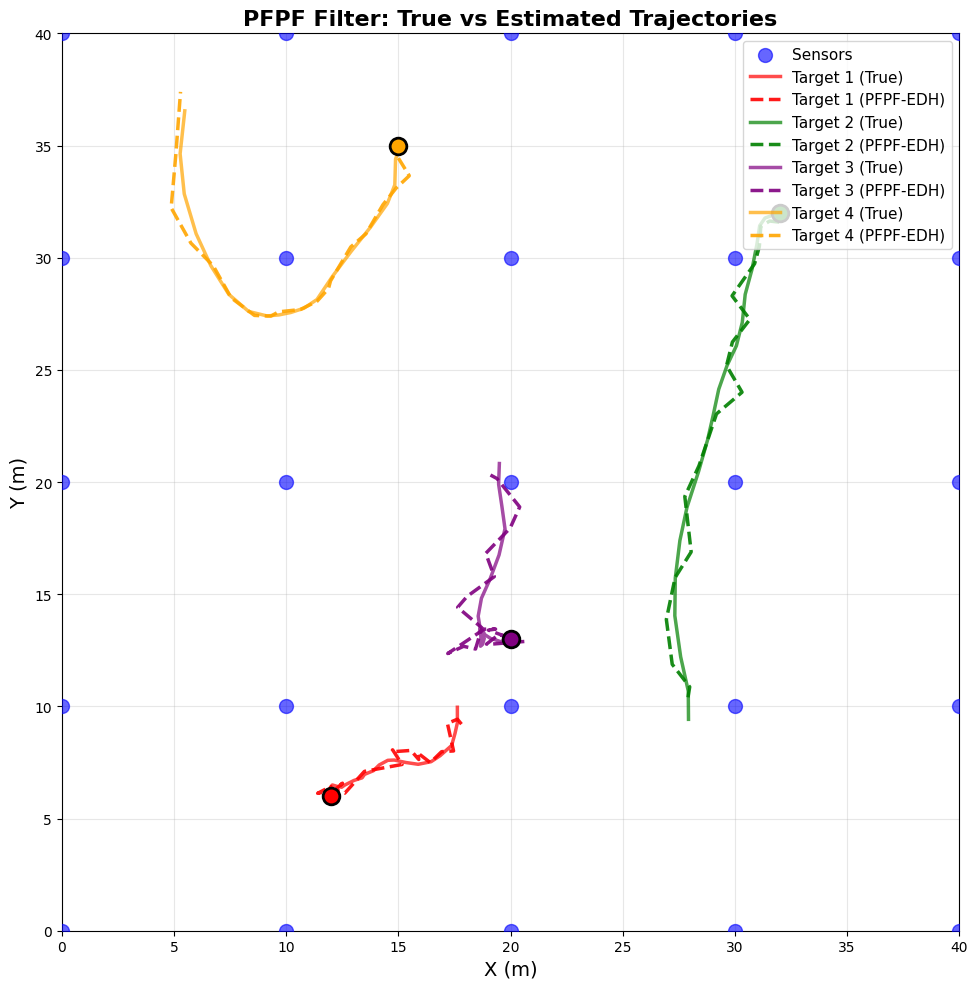

In [32]:
# Plot estimated trajectories
fig, ax = plt.subplots(figsize=(11, 10))

# Plot sensors
sensors = model_params['sensor_positions'].numpy()
ax.scatter(sensors[:, 0], sensors[:, 1], 
          c='blue', marker='o', s=100, label='Sensors', alpha=0.6, zorder=5)

colors = ['red', 'green', 'purple', 'orange']
gt = ground_truth.numpy()
est = pfpf_edh_estimates_no_weights.numpy()

for i in range(model_params['n_targets']):
    x_idx = i * 4
    y_idx = i * 4 + 1
    
    # Ground truth
    x_true = gt[x_idx, :]
    y_true = gt[y_idx, :]
    ax.plot(x_true, y_true, '-', color=colors[i], linewidth=2.5,
           label=f'Target {i+1} (True)', alpha=0.7)
    
    # Estimates
    x_est = est[x_idx, :]
    y_est = est[y_idx, :]
    ax.plot(x_est, y_est, '--', color=colors[i], linewidth=2.5,
           label=f'Target {i+1} (PFPF-EDH)', alpha=0.9, linestyle='dashed')
    
    # Mark start
    ax.plot(x_true[0], y_true[0], 'o', color=colors[i], 
           markersize=12, markeredgecolor='black', markeredgewidth=2)

ax.set_xlabel('X (m)', fontsize=14)
ax.set_ylabel('Y (m)', fontsize=14)
ax.set_title('PFPF Filter: True vs Estimated Trajectories', fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xlim([0, model_params['sim_area_size']])
ax.set_ylim([0, model_params['sim_area_size']])
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

## 8. Summary: Function-to-Algorithm Mapping

| Function | Algorithm Lines | Purpose |
|----------|----------------|----------|
| `compute_lambda_steps()` | Pre-processing | Exponential spacing for lambda |
| `initialize_particles()` | 1-2 | Draw particles from prior and set weights |
| `propagate_particles()` | 7 (LEDH) / 6 (EDH) | Motion model prediction |
| `estimate_covariance()` | 5 (LEDH) / 4 (EDH) | Compute covariance from particles |
| `compute_flow_parameters()` | 16 (LEDH) / 13 (EDH) | Compute A(λ) and b(λ) |
| `particle_flow_ledh()` | 11-21 (LEDH) | Migrate particles with local linearization |
| `particle_flow_edh()` | 10-18 (EDH) | Migrate particles with global linearization |
| `compute_likelihood()` | 24 (LEDH) / 21 (EDH) | Compute p(z_k\|x_k) for weights |
| `pfpf_ledh_filter_step()` | 4-29 (LEDH) | One complete LEDH iteration |
| `pfpf_edh_filter_step()` | 4-27 (EDH) | One complete EDH iteration |
| `run_pfpf_filter()` | 1-30 (LEDH) / 1-27 (EDH) | Full filter on sequence |

### Key Points:

1. **Invertible Mapping Property**:
   - LEDH: Weight update includes determinant term $\theta^i = \prod_j |\det(I + \epsilon_j A_j^i(\lambda))|^{-1}$
   - EDH: No determinant needed because same mapping for all particles

2. **Weight Update**:
   - LEDH: $w_k^i \propto \frac{p(x_k^i|x_{k-1}^i)p(z_k|x_k^i)\theta^i}{p(\eta_0^i|x_{k-1}^i)} w_{k-1}^i$
   - EDH: $w_k^i \propto \frac{p(x_k^i|x_{k-1}^i)p(z_k|x_k^i)}{p(\eta_0^i|x_{k-1}^i)} w_{k-1}^i$

3. **Computational Complexity**:
   - LEDH: $O(N_p S^3 N_\lambda)$ - expensive due to per-particle flow
   - EDH: $O(S^3 N_\lambda + N_p)$ - much faster, shared flow parameters

4. **Theoretical Guarantees**:
   - PFPF maintains particle filter convergence guarantees
   - Particle flow constructs good proposal distribution
   - Weight update corrects for flow approximations